# Bài Toán Phân Cụm Dữ Liệu Đồng Hồ

Trong bài toán này, chúng ta sẽ thực hiện phân cụm dữ liệu đồng hồ dựa trên các đặc tính kỹ thuật, thương hiệu, và các thông số khác. Mục tiêu là tìm ra các nhóm tự nhiên trong dữ liệu để hiểu rõ hơn về phân khúc giá và đặc điểm của từng nhóm.

## Lý Thuyết Về Các Thuật Toán Phân Cụm

### 1. K-Prototypes
- **Mô tả**: K-Prototypes là một thuật toán phân cụm được thiết kế để xử lý dữ liệu hỗn hợp (cả số và phân loại).
- **Cách hoạt động**:
  - Kết hợp K-Means (cho dữ liệu số) và K-Modes (cho dữ liệu phân loại).
  - Sử dụng khoảng cách Euclidean cho dữ liệu số và khoảng cách Hamming cho dữ liệu phân loại.
- **Ưu điểm**: Phù hợp với dữ liệu hỗn hợp.
- **Nhược điểm**: Cần xác định số cụm trước.

### 2. GMM (Gaussian Mixture Model)
- **Mô tả**: GMM là một thuật toán phân cụm xác suất, giả định dữ liệu được sinh ra từ hỗn hợp của nhiều phân phối chuẩn (Gaussian).
- **Cách hoạt động**:
  - Mỗi cụm được mô hình hóa bằng một phân phối chuẩn với các tham số trung bình (μ), ma trận hiệp phương sai (Σ) và trọng số (π).
  - Sử dụng thuật toán Expectation-Maximization (EM) để ước lượng các tham số này.
  - Mỗi điểm dữ liệu có xác suất thuộc về mỗi cụm, điểm được gán vào cụm có xác suất cao nhất.
- **Ưu điểm**:
  - Có thể nhận diện cụm với hình dạng elip (không chỉ hình cầu như K-means).
  - Cung cấp thông tin xác suất về việc điểm dữ liệu thuộc cụm nào.
  - Phù hợp với dữ liệu có phân phối chuẩn.
- **Nhược điểm**:
  - Cần xác định số cụm trước.
  - Nhạy cảm với điểm khởi tạo.
  - Kém hiệu quả với dữ liệu phân loại.

## Lý Thuyết Về Các Phương Pháp Mã Hóa

### 1. Label Encoding
- **Mô tả**: Chuyển đổi các giá trị phân loại thành số nguyên.
- **Ưu điểm**: Đơn giản, dễ triển khai.
- **Nhược điểm**: Có thể gây hiểu nhầm về thứ tự giữa các giá trị.

### 2. One-Hot Encoding
- **Mô tả**: Tạo một cột nhị phân (0 hoặc 1) cho mỗi giá trị phân loại.
- **Ưu điểm**: Tránh được vấn đề thứ tự giả.
- **Nhược điểm**: Làm tăng số chiều dữ liệu.

### 3. Target Encoding
- **Mô tả**: Thay thế các giá trị phân loại bằng trung bình của cột mục tiêu.
- **Ưu điểm**: Giữ được thông tin từ cột mục tiêu.
- **Nhược điểm**: Có thể gây overfitting.

## Lý Thuyết Về Các Metrics Đánh Giá

### 1. Silhouette Score
- **Mô tả**: Đánh giá mức độ tách biệt giữa các cụm và sự gắn kết trong từng cụm.
- **Giá trị**: Nằm trong khoảng [-1, 1]. Giá trị càng cao càng tốt.

### 2. Davies-Bouldin Index
- **Mô tả**: Đánh giá sự phân tách và độ nhỏ gọn của các cụm.
- **Giá trị**: Giá trị càng nhỏ càng tốt.

### 3. Calinski-Harabasz Index
- **Mô tả**: Đánh giá tỷ lệ giữa độ phân tán giữa các cụm và trong từng cụm.
- **Giá trị**: Giá trị càng lớn càng tốt.

In [37]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from kmodes.kprototypes import KPrototypes
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings('ignore')

# Thiết lập style cho các biểu đồ
sns.set_style("whitegrid")  # Using direct seaborn styling instead of plt.style.use
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

## 1. Khám Phá Dữ Liệu (Exploratory Data Analysis)

Trước tiên, chúng ta cần đọc dữ liệu và tìm hiểu cấu trúc của nó để có thể tiền xử lý phù hợp.

In [38]:
# Đọc dữ liệu
file_path = '../dataset/train_segmented.csv'
df = pd.read_csv(file_path)

# Create a copy of the original dataframe for later reference
df_original = df.copy()

# Hiển thị thông tin cơ bản về dữ liệu
print("=== THÔNG TIN CƠ BẢN VỀ DỮ LIỆU ===")
print(f"Số lượng mẫu: {df.shape[0]}")
print(f"Số lượng đặc trưng: {df.shape[1]}")
print("\n=== KIỂM TRA KIỂU DỮ LIỆU ===")
print(df.info())

print("\n=== THỐNG KÊ MÔ TẢ CHO DỮ LIỆU SỐ ===")
print(df.describe())

print("\n=== SỐ LƯỢNG GIÁ TRỊ DUY NHẤT TRONG MỖI CỘT ===")
unique_counts = df.nunique().sort_values(ascending=False)
print(unique_counts)

# Kiểm tra giá trị null
print("\n=== KIỂM TRA GIÁ TRỊ NULL ===")
null_counts = df.isnull().sum()
print(null_counts[null_counts > 0] if any(null_counts > 0) else "Không có giá trị null")

=== THÔNG TIN CƠ BẢN VỀ DỮ LIỆU ===
Số lượng mẫu: 5665
Số lượng đặc trưng: 15

=== KIỂM TRA KIỂU DỮ LIỆU ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5665 entries, 0 to 5664
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   case_material     5665 non-null   object 
 1   band_material     5665 non-null   object 
 2   case_back         5665 non-null   object 
 3   bezel_material    5665 non-null   object 
 4   brand             5665 non-null   object 
 5   gender            5665 non-null   object 
 6   movement          5665 non-null   object 
 7   watch_style       5665 non-null   object 
 8   case_thickness    5665 non-null   float64
 9   crystal           5665 non-null   object 
 10  hands             5665 non-null   object 
 11  dial_markers      5665 non-null   object 
 12  case_diameter     5665 non-null   float64
 13  water_resistance  5665 non-null   float64
 14  price_segment     5665 non-

### Phân tích phân phối của các đặc trưng số

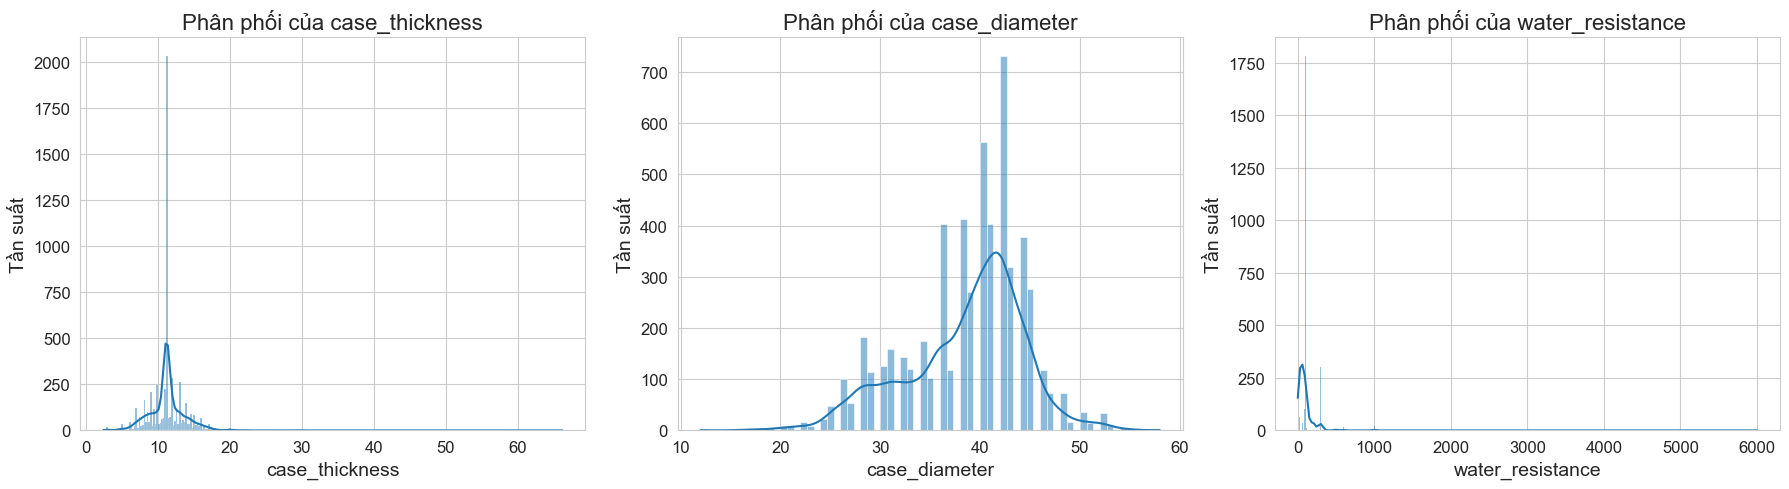

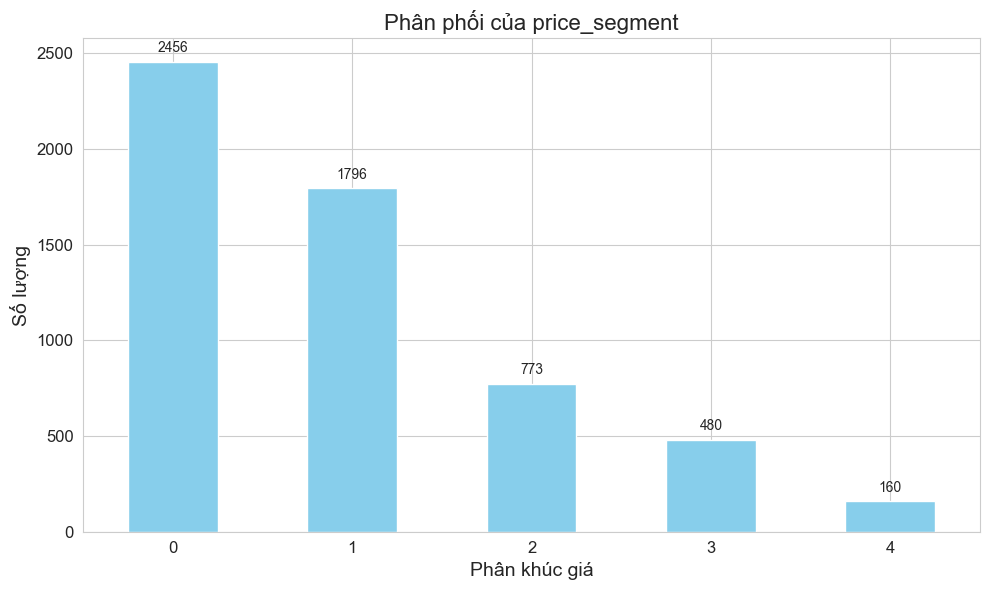

In [39]:
# Phân tích phân phối của các đặc trưng số
numerical_features = ['case_thickness', 'case_diameter', 'water_resistance']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, feature in enumerate(numerical_features):
    sns.histplot(df[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'Phân phối của {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Tần suất')

plt.tight_layout()
plt.show()

# Biểu đồ phân phối của price_segment
plt.figure(figsize=(10, 6))
segment_counts = df['price_segment'].value_counts().sort_index()
ax = segment_counts.plot(kind='bar', color='skyblue')
plt.title('Phân phối của price_segment')
plt.xlabel('Phân khúc giá')
plt.ylabel('Số lượng')
plt.xticks(rotation=0)

# Thêm số lượng trên mỗi cột
for i, v in enumerate(segment_counts):
    ax.text(i, v + 50, str(v), ha='center')

plt.tight_layout()
plt.show()

### Phân tích mối quan hệ giữa các đặc trưng số

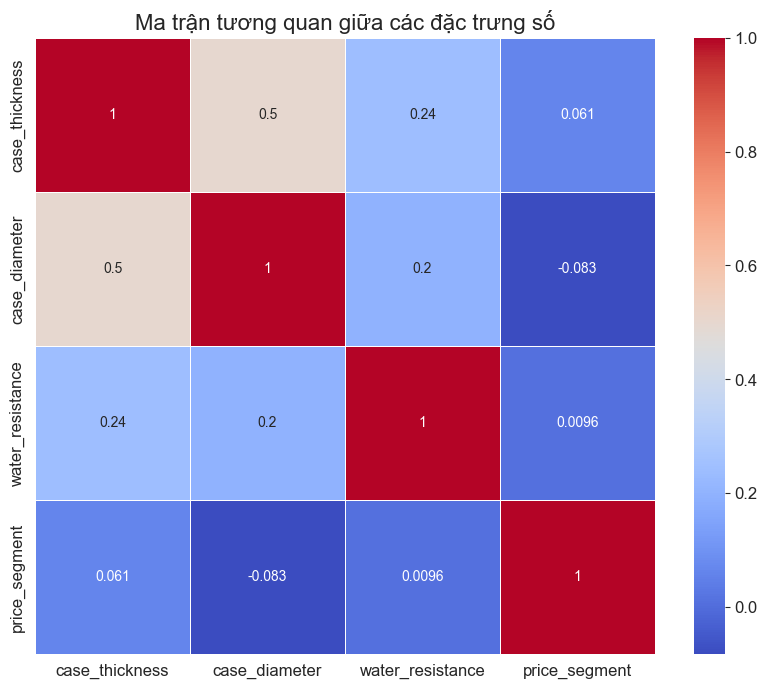

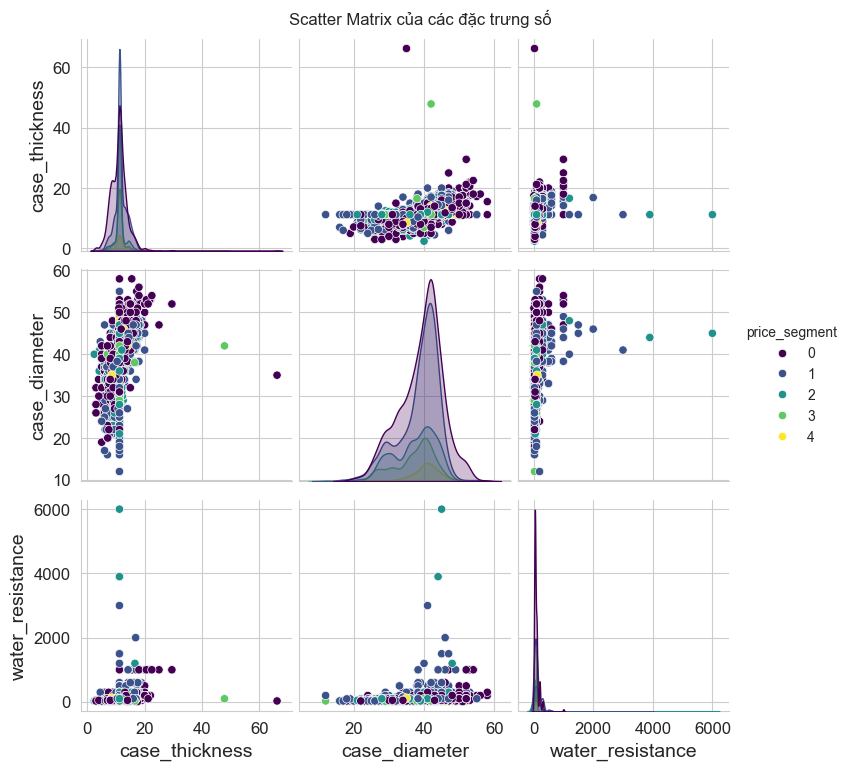

In [40]:
# Phân tích mối quan hệ giữa các đặc trưng số
plt.figure(figsize=(10, 8))
numerical_df = df[numerical_features + ['price_segment']]
correlation = numerical_df.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Ma trận tương quan giữa các đặc trưng số')
plt.show()

# Biểu đồ scatter matrix để xem mối quan hệ giữa các đặc trưng số
sns.pairplot(numerical_df, hue='price_segment', palette='viridis')
plt.suptitle('Scatter Matrix của các đặc trưng số', y=1.02)
plt.show()

### Phân tích đặc trưng phân loại

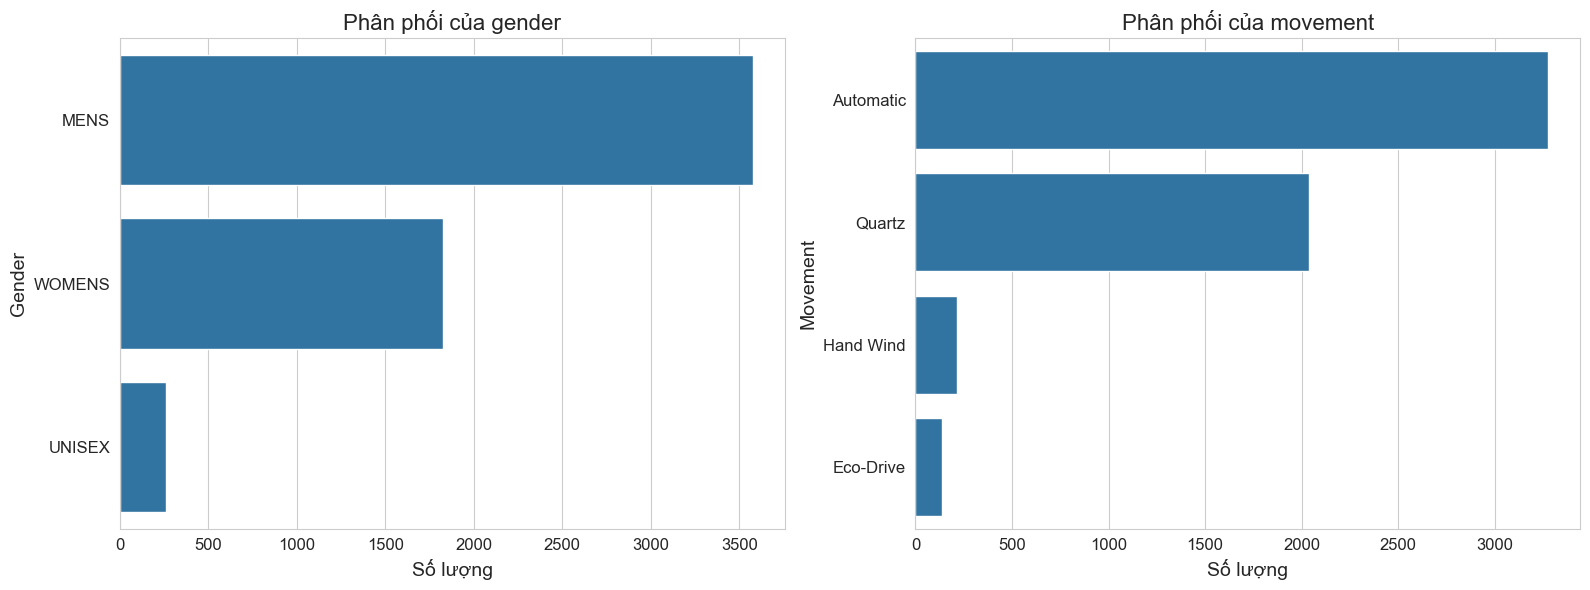

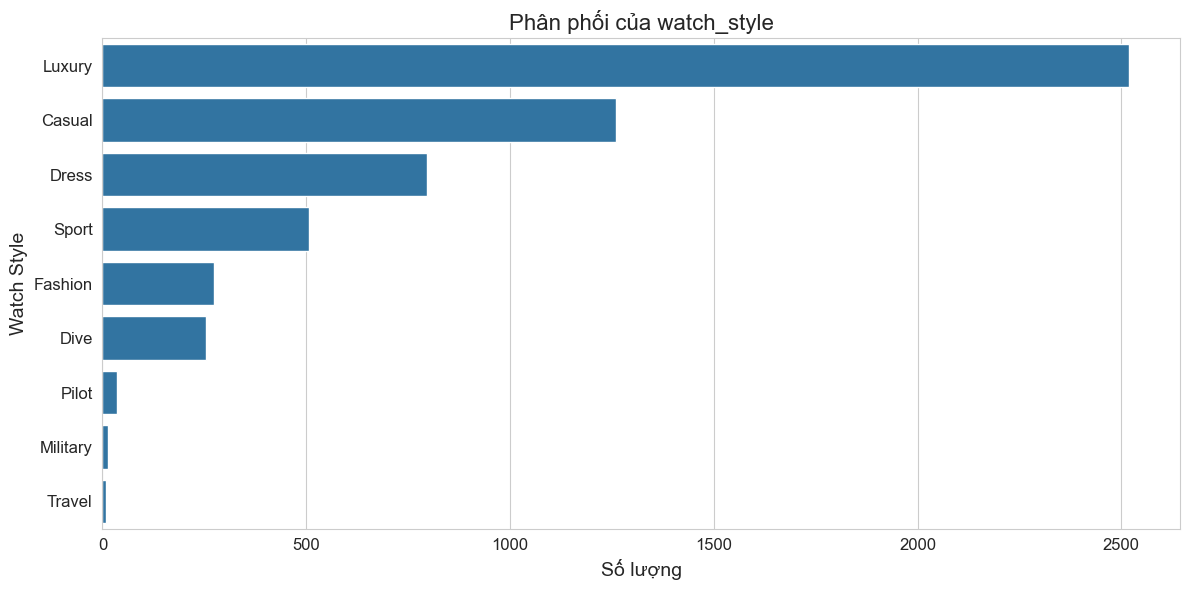

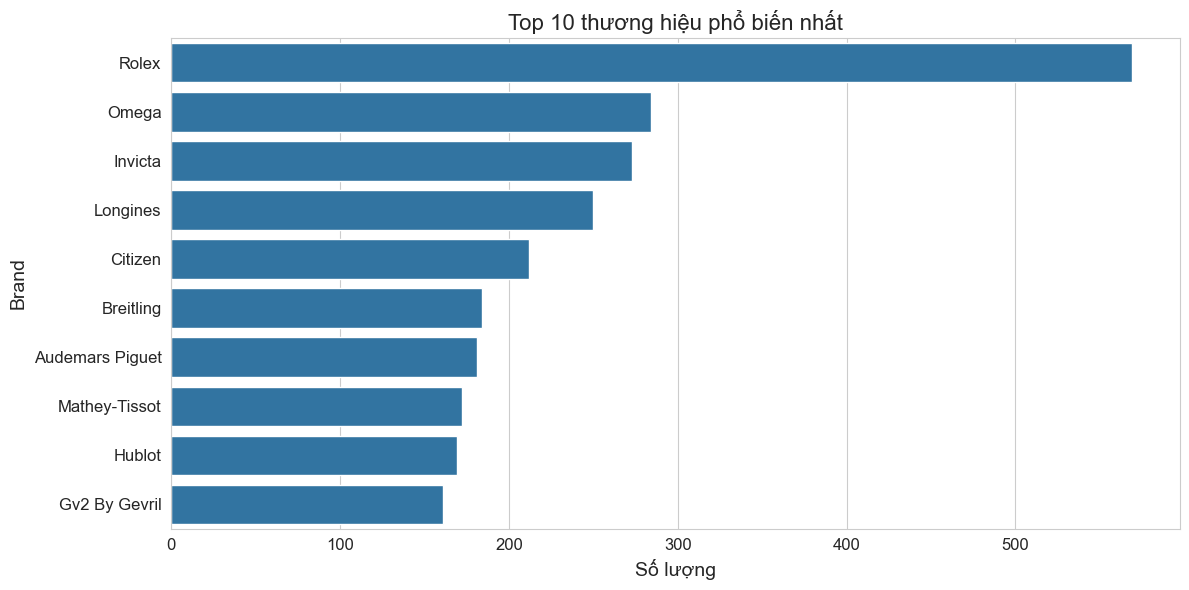

In [41]:
# Phân tích các đặc trưng phân loại
categorical_features = ['case_material', 'band_material', 'case_back', 'bezel_material', 
                        'brand', 'gender', 'movement', 'watch_style', 'crystal', 
                        'hands', 'dial_markers']

# Hiển thị phân phối của 'gender' và 'movement'
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.countplot(y=df['gender'], ax=axes[0], order=df['gender'].value_counts().index)
axes[0].set_title('Phân phối của gender')
axes[0].set_xlabel('Số lượng')
axes[0].set_ylabel('Gender')

sns.countplot(y=df['movement'], ax=axes[1], order=df['movement'].value_counts().index)
axes[1].set_title('Phân phối của movement')
axes[1].set_xlabel('Số lượng')
axes[1].set_ylabel('Movement')

plt.tight_layout()
plt.show()

# Hiển thị phân phối của 'watch_style'
plt.figure(figsize=(12, 6))
sns.countplot(y=df['watch_style'], order=df['watch_style'].value_counts().index)
plt.title('Phân phối của watch_style')
plt.xlabel('Số lượng')
plt.ylabel('Watch Style')
plt.tight_layout()
plt.show()

# Phân tích top 10 thương hiệu phổ biến nhất
plt.figure(figsize=(12, 6))
top_brands = df['brand'].value_counts().nlargest(10)
sns.barplot(x=top_brands.values, y=top_brands.index)
plt.title('Top 10 thương hiệu phổ biến nhất')
plt.xlabel('Số lượng')
plt.ylabel('Brand')
plt.tight_layout()
plt.show()

### Phân tích mối quan hệ giữa đặc trưng phân loại và price_segment

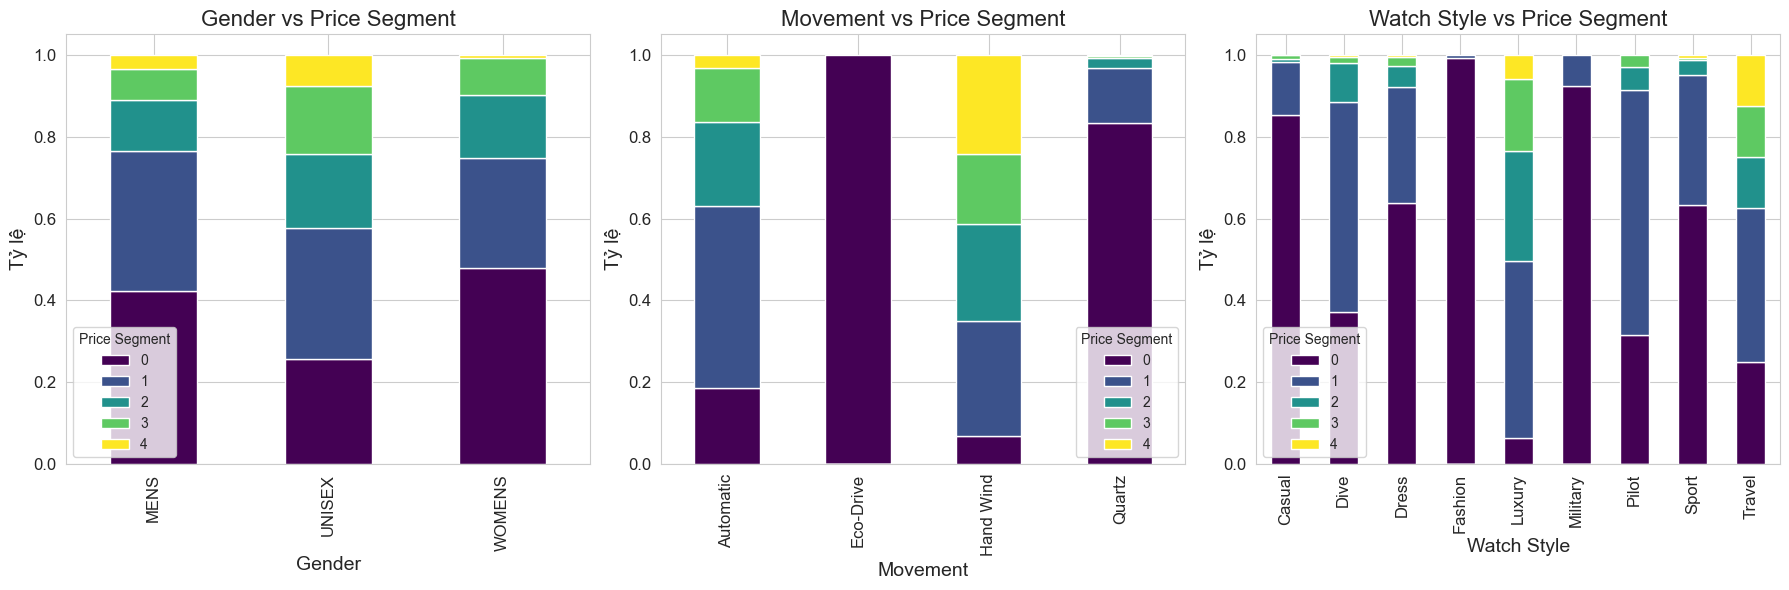

<Figure size 1400x800 with 0 Axes>

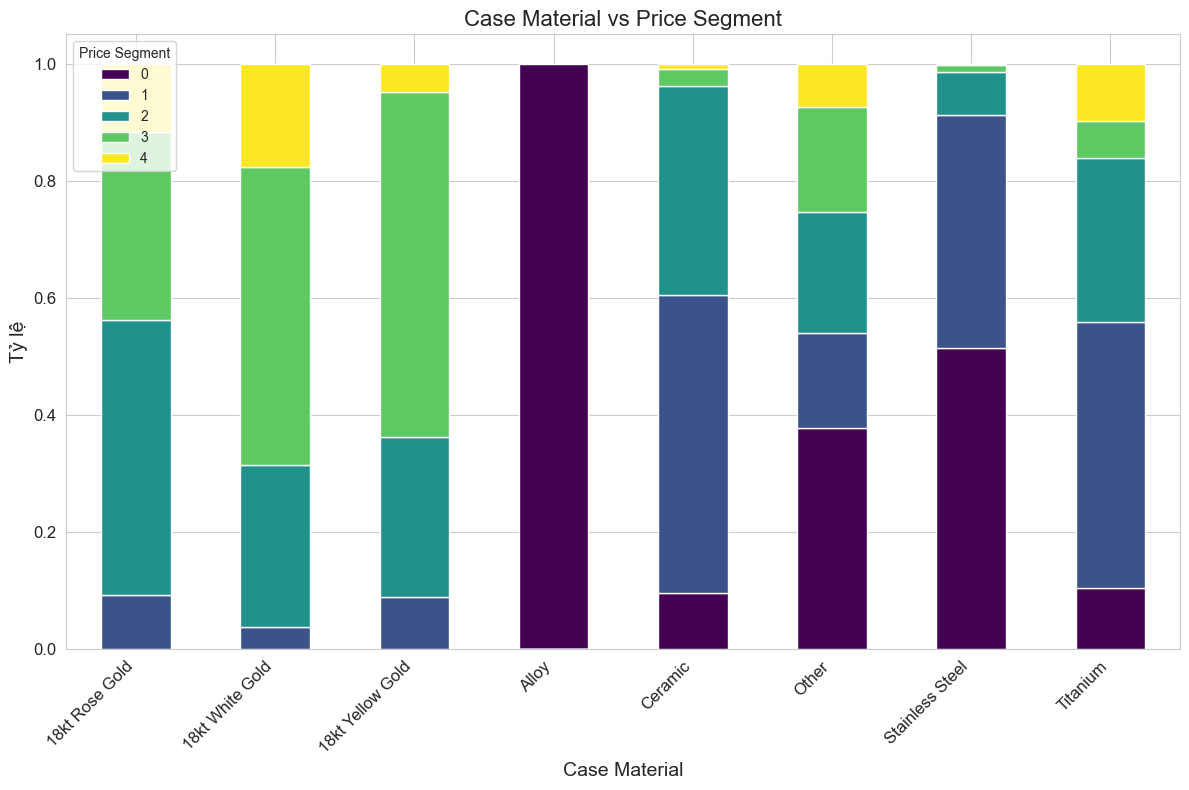

In [42]:
# Phân tích mối quan hệ giữa 'gender', 'movement', 'watch_style' và 'price_segment'
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Gender vs price_segment
gender_price = pd.crosstab(df['gender'], df['price_segment'], normalize='index')
gender_price.plot(kind='bar', stacked=True, ax=axes[0], colormap='viridis')
axes[0].set_title('Gender vs Price Segment')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Tỷ lệ')
axes[0].legend(title='Price Segment')

# Movement vs price_segment
movement_price = pd.crosstab(df['movement'], df['price_segment'], normalize='index')
movement_price.plot(kind='bar', stacked=True, ax=axes[1], colormap='viridis')
axes[1].set_title('Movement vs Price Segment')
axes[1].set_xlabel('Movement')
axes[1].set_ylabel('Tỷ lệ')
axes[1].legend(title='Price Segment')

# Watch Style vs price_segment
style_price = pd.crosstab(df['watch_style'], df['price_segment'], normalize='index')
style_price.plot(kind='bar', stacked=True, ax=axes[2], colormap='viridis')
axes[2].set_title('Watch Style vs Price Segment')
axes[2].set_xlabel('Watch Style')
axes[2].set_ylabel('Tỷ lệ')
axes[2].legend(title='Price Segment')

plt.tight_layout()
plt.show()

# Phân tích mối quan hệ giữa case_material và price_segment
plt.figure(figsize=(14, 8))
case_material_price = pd.crosstab(df['case_material'].apply(lambda x: x if df['case_material'].value_counts()[x] > 100 else 'Other'), 
                                 df['price_segment'], normalize='index')
case_material_price.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Case Material vs Price Segment')
plt.xlabel('Case Material')
plt.ylabel('Tỷ lệ')
plt.legend(title='Price Segment')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 2. Tiền Xử Lý Dữ Liệu

Trong phần này, chúng ta sẽ:
1. Phân loại các cột thành dữ liệu số và dữ liệu phân loại
2. Chuẩn hóa dữ liệu số bằng MinMaxScaler
3. Mã hóa dữ liệu phân loại bằng các phương pháp khác nhau

### ✅ 1. Mã hóa dữ liệu cho K-Prototypes (df_kproto)

In [65]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Các cột số & phân loại
numerical_cols = ['case_thickness', 'case_diameter', 'water_resistance']
onehot_cols = ['gender', 'movement', 'watch_style']
categorical_cols = ['case_material', 'band_material', 'case_back', 'bezel_material', 
                    'brand', 'crystal', 'hands', 'dial_markers']
k_categorical_cols = onehot_cols + categorical_cols

all_categorical_cols = numerical_cols + categorical_cols


# Scale dữ liệu số
scaler = MinMaxScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Category pooling (gộp nhóm các giá trị hiếm)
def pool_categories(series, threshold=0.01):
    value_counts = series.value_counts(normalize=True)
    rare = value_counts[value_counts < threshold].index
    return series.apply(lambda x: 'Other' if x in rare else x)

# Gộp giá trị hiếm
df_pooled = df.copy()
high_card_cols = [col for col in categorical_cols if df[col].nunique() > 50]
for col in high_card_cols:
    df_pooled[col] = pool_categories(df[col])

# Label Encoding
df_kproto_improved = df_pooled.copy()
label_encoders_improved = {}
for col in k_categorical_cols:
    le = LabelEncoder()
    df_kproto_improved[col] = le.fit_transform(df_kproto_improved[col])
    label_encoders_improved[col] = le

df_kproto = df_kproto_improved.copy()

print("\n=== KIỂM TRA DỮ LIỆU SAU KHI TIỀN XỬ LÝ CẢI TIẾN ===")
print("Dữ liệu cho K-Prototypes với category pooling:")
print(df_kproto.head())



=== KIỂM TRA DỮ LIỆU SAU KHI TIỀN XỬ LÝ CẢI TIẾN ===
Dữ liệu cho K-Prototypes với category pooling:
   case_material  band_material  case_back  bezel_material  brand  gender  \
0              7              6         45               1      1       2   
1              7              9         28               9      8       0   
2              7              8         28               9     29       0   
3              7              6         28               8     20       2   
4              7              9         28               9     16       0   

   movement  watch_style  case_thickness  crystal  hands  dial_markers  \
0         0            4        0.100313        4     12             4   
1         3            7        0.111285        1     13             4   
2         3            7        0.147335        4     12             4   
3         3            4        0.086207        3     13             6   
4         3            0        0.137871        3     13          

In [66]:
from sklearn.preprocessing import OneHotEncoder

# Frequency Encoding cho các cột high-card
df_freq_encoded = df.copy()
for col in high_card_cols:
    freq_map = df[col].value_counts(normalize=True).to_dict()
    df_freq_encoded[col] = df[col].map(freq_map)

# One-hot Encoding cho các cột onehot
onehot_encoder = OneHotEncoder(sparse_output=False, drop='first')
onehot_encoded = pd.DataFrame(
    onehot_encoder.fit_transform(df_pooled[onehot_cols]),
    columns=onehot_encoder.get_feature_names_out(onehot_cols)
)

# Kết hợp dữ liệu số + onehot + freq
df_gmm = pd.concat([
    df[numerical_cols],
    onehot_encoded,
    df_freq_encoded[high_card_cols]
], axis=1)

print("\n=== KIỂM TRA DỮ LIỆU SAU KHI TIỀN XỬ LÝ CẢI TIẾN ===")
print("\nDữ liệu cho One-hot encoding và Frequency encoding:")
print(df_gmm.head())

# save processed data
df_kproto.to_csv('../dataset/train_segmented_kproto.csv', index=False)
df_gmm.to_csv('../dataset/train_segmented_processed.csv', index=False)


=== KIỂM TRA DỮ LIỆU SAU KHI TIỀN XỬ LÝ CẢI TIẾN ===

Dữ liệu cho One-hot encoding và Frequency encoding:
   case_thickness  case_diameter  water_resistance  gender_UNISEX  \
0        0.100313       0.478261          0.007837            0.0   
1        0.111285       0.565217          0.007837            0.0   
2        0.147335       0.717391          0.016175            0.0   
3        0.086207       0.391304          0.004502            0.0   
4        0.137871       0.608696          0.007837            0.0   

   gender_WOMENS  movement_Eco-Drive  movement_Hand Wind  movement_Quartz  \
0            1.0                 0.0                 0.0              0.0   
1            0.0                 0.0                 0.0              1.0   
2            0.0                 0.0                 0.0              1.0   
3            1.0                 0.0                 0.0              1.0   
4            0.0                 0.0                 0.0              1.0   

   watch_style_

Applying PCA for dimensionality reduction...
Original dimensions: 23
Reduced dimensions with PCA: 13
Explained variance ratio: [0.29801376 0.18257307 0.10392137 0.08124671 0.06346896 0.0481619
 0.03367873 0.02968981 0.02948432 0.02748457 0.02462399 0.01788067
 0.01550684]
Total explained variance: 0.9557


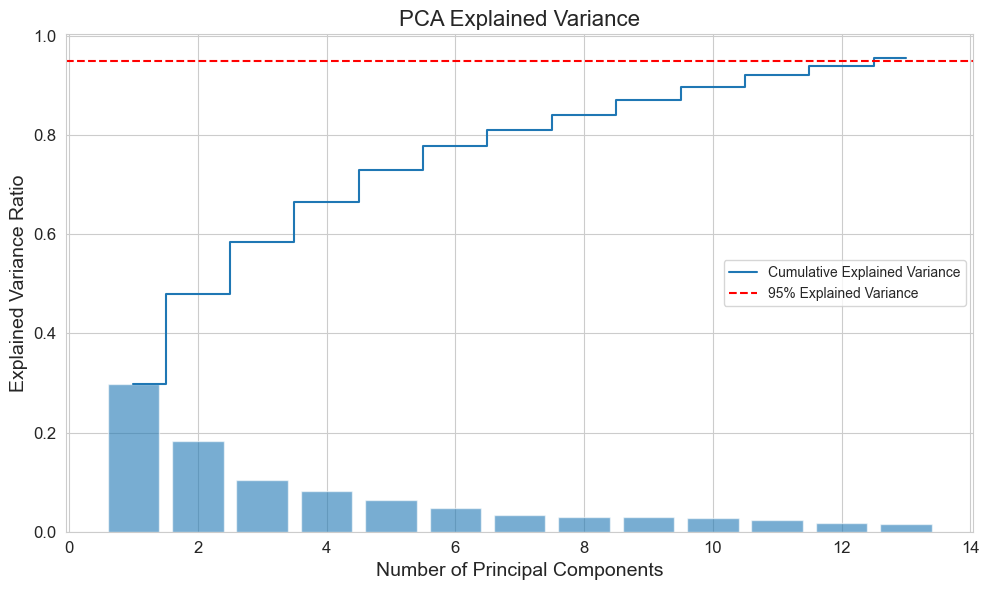

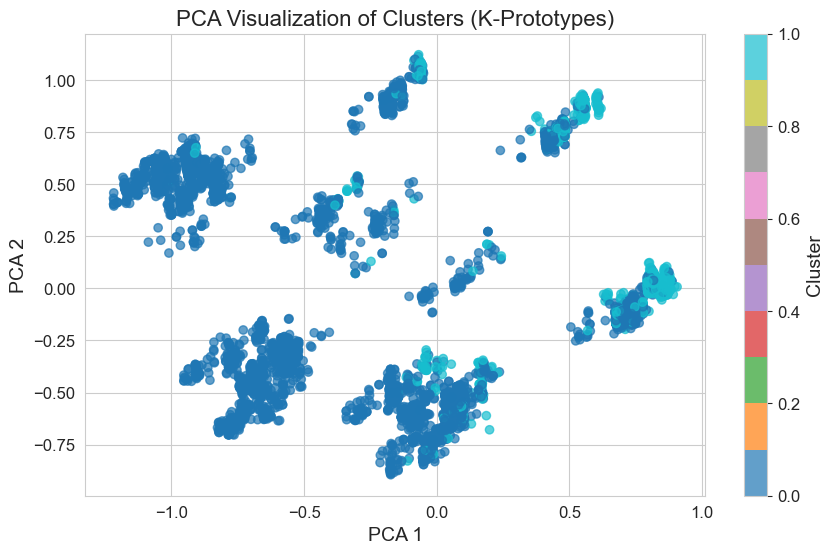

In [71]:
# Apply PCA for dimensionality reduction 
# This will help with visualization and improve performance of clustering algorithms
from sklearn.decomposition import PCA

print("Applying PCA for dimensionality reduction...")
pca = PCA(n_components=0.95)  # Keep 95% of variance
df_pca = pd.DataFrame(pca.fit_transform(df_gmm))

print(f"Original dimensions: {df_gmm.shape[1]}")
print(f"Reduced dimensions with PCA: {df_pca.shape[1]}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.4f}")

# Visualize the explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.6)
plt.step(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), where='mid', label='Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Nếu bạn có `df_pca` và `kproto_clusters`
plt.figure(figsize=(10, 6))
plt.scatter(df_pca[0], df_pca[1], c=kproto_clusters, cmap='tab10', alpha=0.7)
plt.title('PCA Visualization of Clusters (K-Prototypes)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.show()


## 3. Triển Khai Các Mô Hình Phân Cụm

Chúng ta sẽ triển khai hai mô hình phân cụm: K-Prototypes và Gaussian Mixture Model (GMM).

### 3.1. Xác định số cụm tối ưu

Trước khi áp dụng các thuật toán phân cụm, chúng ta cần xác định số cụm tối ưu. Chúng ta sẽ sử dụng phương pháp Elbow và Silhouette Score.


Đang đánh giá số cụm tối ưu bằng nhiều phương pháp...

Đánh giá với k=2...
k=2, Silhouette=0.1844, DB=1.9110, CH=1140.7167

Đánh giá với k=3...
k=3, Silhouette=0.0940, DB=2.8243, CH=837.0246

Đánh giá với k=4...
k=4, Silhouette=0.0751, DB=3.3327, CH=605.7195

Đánh giá với k=5...
k=5, Silhouette=0.0554, DB=3.5967, CH=506.9645

Đánh giá với k=6...
k=6, Silhouette=0.0547, DB=3.4965, CH=441.5368

Đánh giá với k=7...
k=7, Silhouette=0.0502, DB=3.7200, CH=376.5369

Đánh giá với k=8...
k=8, Silhouette=0.0505, DB=3.6359, CH=342.3193

Đánh giá với k=9...
k=9, Silhouette=0.0469, DB=3.7375, CH=313.7858

Đánh giá với k=10...
k=10, Silhouette=0.0501, DB=3.5541, CH=291.0843


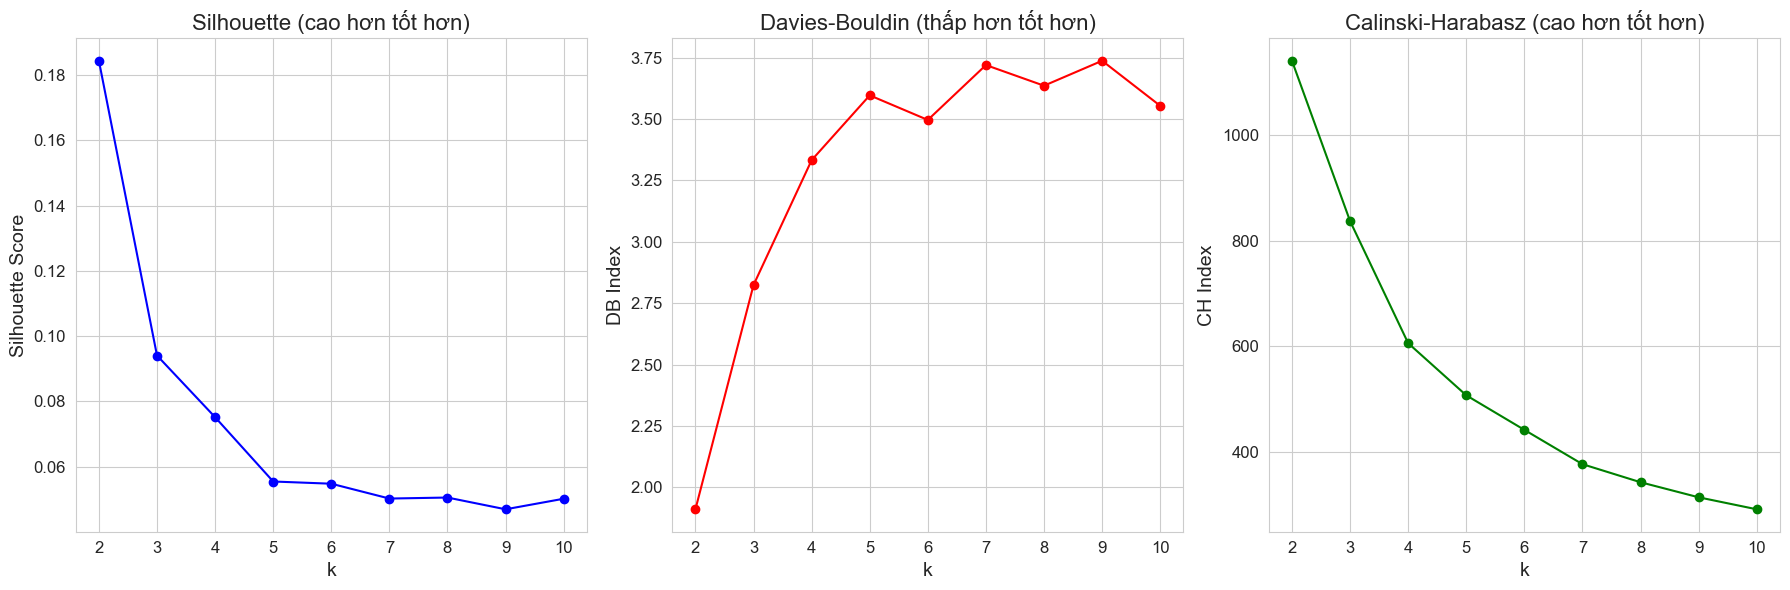


Số cụm tối ưu (theo từng metric): Sil=2, DB=2, CH=2
Số cụm tối ưu được chọn: 2

Đang áp dụng K-Prototypes...
Số lượng phần tử mỗi cụm: (array([0, 1], dtype=uint16), array([4252, 1413]))

Cụm 0:
Đặc trưng số:
case_thickness       11.234138
case_diameter        38.906406
water_resistance    100.942019
dtype: float64

Phân phối price_segment:
price_segment
0    0.577611
1    0.422389
Name: proportion, dtype: float64

Top 3 thương hiệu:
brand
Invicta     273
Longines    250
Omega       241
Name: count, dtype: int64

Cụm 1:
Đặc trưng số:
case_thickness      11.301919
case_diameter       37.600064
water_resistance    92.505238
dtype: float64

Phân phối price_segment:
price_segment
2    0.547063
3    0.339703
4    0.113234
Name: proportion, dtype: float64

Top 3 thương hiệu:
brand
Rolex              531
Audemars Piguet    179
Hublot             128
Name: count, dtype: int64


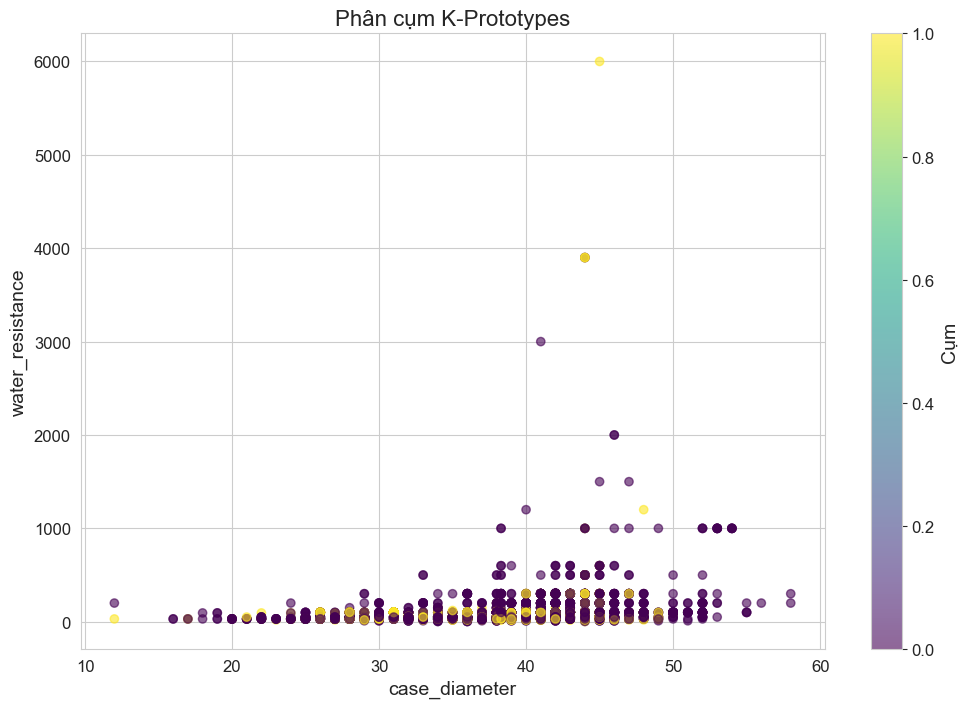

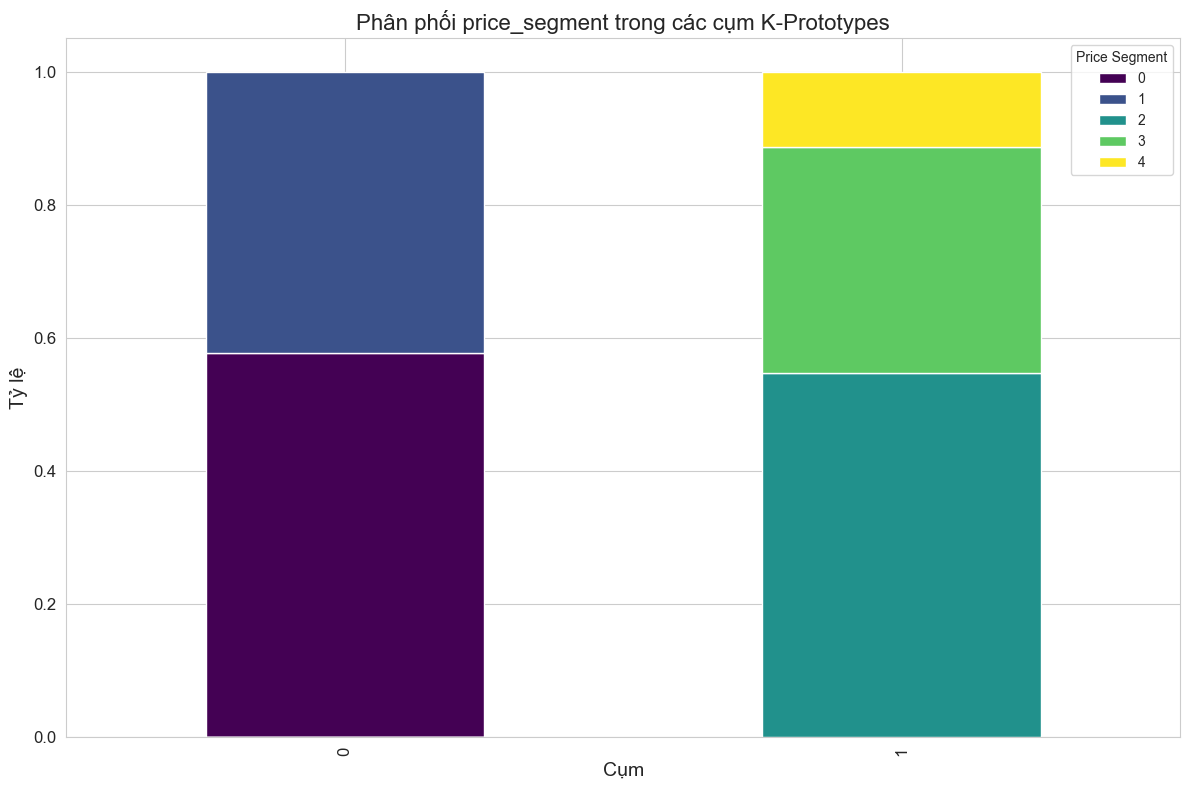


Đang xác định số cụm tối ưu cho GMM...
n_components=2, BIC=-121306.14, AIC=-122694.33
n_components=3, BIC=-157353.79, AIC=-159439.40
n_components=4, BIC=-199112.51, AIC=-201895.53
n_components=5, BIC=-225623.31, AIC=-229103.75
n_components=6, BIC=-246974.34, AIC=-251152.19
n_components=7, BIC=-254688.74, AIC=-259564.01
n_components=8, BIC=-293632.50, AIC=-299205.19
n_components=9, BIC=-308747.88, AIC=-315017.98
n_components=10, BIC=-314842.81, AIC=-321810.33


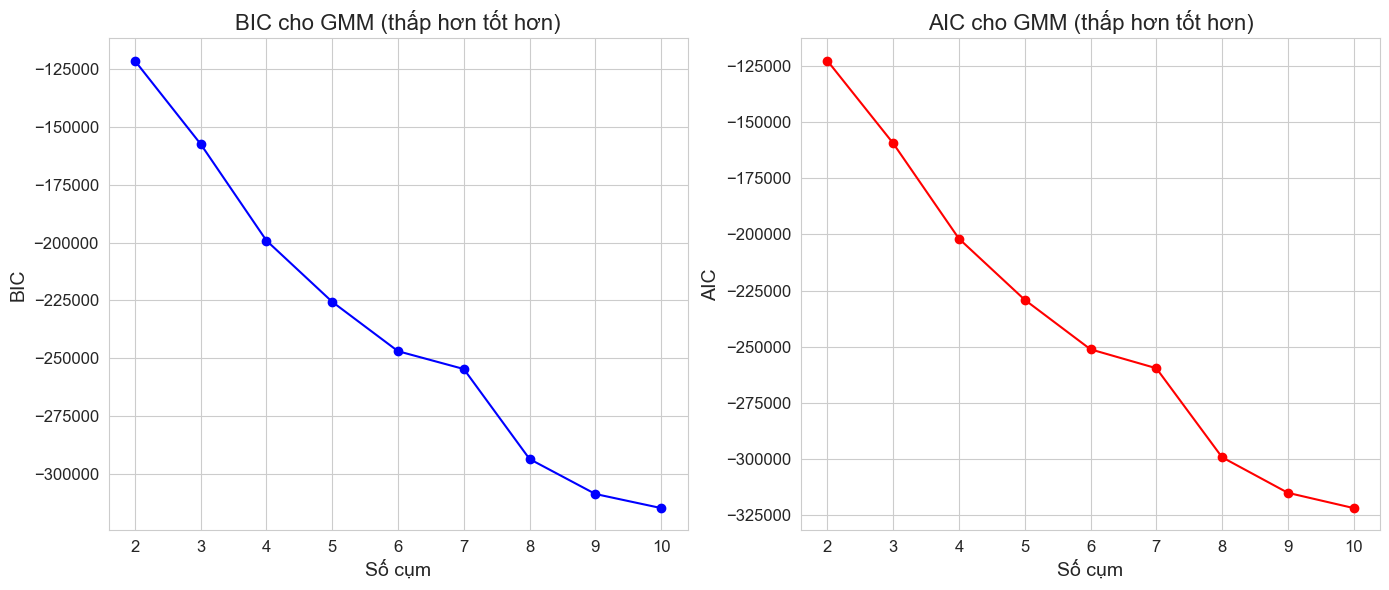

Số cụm tối ưu cho GMM theo BIC: 10
GMM Clusters: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([791, 633, 797, 479, 400, 528, 253, 523, 865, 396]))


In [69]:
# Thêm các phương pháp tìm k tối ưu
print("Đang đánh giá số cụm tối ưu bằng nhiều phương pháp...")

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np

# Chuẩn bị danh sách để lưu các giá trị metric
silhouette_scores = []
db_scores = []
ch_scores = []
K = range(2, 11)

# Tạo bản sao dữ liệu để mã hóa cho các thuật toán metric
# Chuyển đổi tất cả cột sang dạng số (cần thiết cho các metric)
from sklearn.preprocessing import OneHotEncoder

# Xác định cột số và cột phân loại
numeric_cols = [col for col in df_kproto.columns if col not in k_categorical_cols]

# Xác định indices của các cột phân loại
categorical_indices = [df_kproto.columns.get_loc(col) for col in k_categorical_cols]
print(f"Categorical indices: {categorical_indices}")

# One-hot encoding cho cột phân loại
encoder = OneHotEncoder(sparse_output=False, drop='first')
categorical_encoded = encoder.fit_transform(df_kproto[k_categorical_cols])
categorical_col_names = encoder.get_feature_names_out(k_categorical_cols)

# Kết hợp cột số và cột đã mã hóa
df_encoded = pd.DataFrame(df_kproto[numeric_cols].values, columns=numeric_cols)
df_encoded = pd.concat([
    df_encoded, 
    pd.DataFrame(categorical_encoded, columns=categorical_col_names)
], axis=1)

# Tính toán các metric cho các giá trị k khác nhau
for k in K:
    try:
        print(f"Đánh giá với k={k}...")
        kproto = KPrototypes(n_clusters=k, random_state=42, max_iter=100)
        clusters = kproto.fit_predict(df_kproto, categorical=categorical_indices)
        
        # Tính các metric
        silhouette = silhouette_score(df_encoded, clusters)
        db = davies_bouldin_score(df_encoded, clusters)
        ch = calinski_harabasz_score(df_encoded, clusters)
        
        silhouette_scores.append(silhouette)
        db_scores.append(db)
        ch_scores.append(ch)
        
        print(f"k={k}, Silhouette={silhouette:.4f}, Davies-Bouldin={db:.4f}, Calinski-Harabasz={ch:.4f}")
    except Exception as e:
        print(f"Lỗi với k={k}: {e}")
        silhouette_scores.append(float('nan'))
        db_scores.append(float('nan'))
        ch_scores.append(float('nan'))

# Trực quan hóa kết quả
plt.figure(figsize=(18, 6))

# Silhouette Score (giá trị càng cao càng tốt)
plt.subplot(1, 3, 1)
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Số cụm (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method (cao hơn tốt hơn)')
plt.grid(True)

# Davies-Bouldin Index (giá trị càng thấp càng tốt)
plt.subplot(1, 3, 2)
plt.plot(K, db_scores, 'ro-')
plt.xlabel('Số cụm (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index Method (thấp hơn tốt hơn)')
plt.grid(True)

# Calinski-Harabasz Index (giá trị càng cao càng tốt)
plt.subplot(1, 3, 3)
plt.plot(K, ch_scores, 'go-')
plt.xlabel('Số cụm (k)')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index Method (cao hơn tốt hơn)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Tìm k tối ưu dựa trên các phương pháp - với xử lý NaN
# Xử lý trường hợp tất cả giá trị là NaN
if all(np.isnan(silhouette_scores)):
    print("Cảnh báo: Tất cả giá trị Silhouette Score là NaN")
    best_k_silhouette = 4  # Giá trị mặc định
else:
    best_k_silhouette = K[np.nanargmax(silhouette_scores)]

if all(np.isnan(db_scores)):
    print("Cảnh báo: Tất cả giá trị Davies-Bouldin Index là NaN")
    best_k_db = 4  # Giá trị mặc định
else:
    best_k_db = K[np.nanargmin(db_scores)]

if all(np.isnan(ch_scores)):
    print("Cảnh báo: Tất cả giá trị Calinski-Harabasz Index là NaN")
    best_k_ch = 4  # Giá trị mặc định
else:
    best_k_ch = K[np.nanargmax(ch_scores)]

print(f"Số cụm tối ưu theo Silhouette Score: {best_k_silhouette}")
print(f"Số cụm tối ưu theo Davies-Bouldin Index: {best_k_db}")
print(f"Số cụm tối ưu theo Calinski-Harabasz Index: {best_k_ch}")

# Xác định k tối ưu chung bằng bỏ phiếu hoặc sử dụng giá trị mặc định
if all(np.isnan(silhouette_scores)) and all(np.isnan(db_scores)) and all(np.isnan(ch_scores)):
    most_common_k = 4  # Giá trị mặc định nếu tất cả đều là NaN
else:
    from collections import Counter
    # Lọc các giá trị không phải NaN
    votes = [k for k in [best_k_silhouette, best_k_db, best_k_ch] if not np.isnan(k)]
    if votes:
        most_common_k = Counter(votes).most_common(1)[0][0]
    else:
        most_common_k = 4  # Giá trị mặc định

print(f"\nKết quả bỏ phiếu: {votes}")
print(f"Số cụm tối ưu được đề xuất: {most_common_k}")

# Cập nhật số cụm tối ưu cho K-Prototypes
k_prototypes_n_clusters = most_common_k
print(f"\nSố cụm tối ưu K-Prototypes đã được cập nhật thành: {k_prototypes_n_clusters}")

Common t-SNE Computation Code


### 3.2 K-Prototypes

Đang áp dụng K-Prototypes...
K-Prototypes Clusters: (array([0, 1], dtype=uint16), array([3145, 2520]))

=== ĐẶC ĐIỂM CỦA CÁC CỤM K-PROTOTYPES ===

Cụm 0:
Đặc trưng số:
case_thickness      11.614377
case_diameter       38.743929
water_resistance    95.761790
dtype: float64

Phân phối price_segment:
price_segment
1    0.406041
2    0.231161
0    0.165024
3    0.147536
4    0.050238
Name: proportion, dtype: float64

Top 3 thương hiệu phổ biến nhất:
brand
Rolex              552
Omega              224
Audemars Piguet    174
Name: count, dtype: int64

Cụm 1:
Đặc trưng số:
case_thickness       10.797599
case_diameter        38.376695
water_resistance    102.676404
dtype: float64

Phân phối price_segment:
price_segment
0    0.768651
1    0.205952
2    0.018254
3    0.006349
4    0.000794
Name: proportion, dtype: float64

Top 3 thương hiệu phổ biến nhất:
brand
Invicta          198
Mathey-Tissot    169
Citizen          146
Name: count, dtype: int64
K-Prototypes Clusters: (array([0, 1], dtype=uin

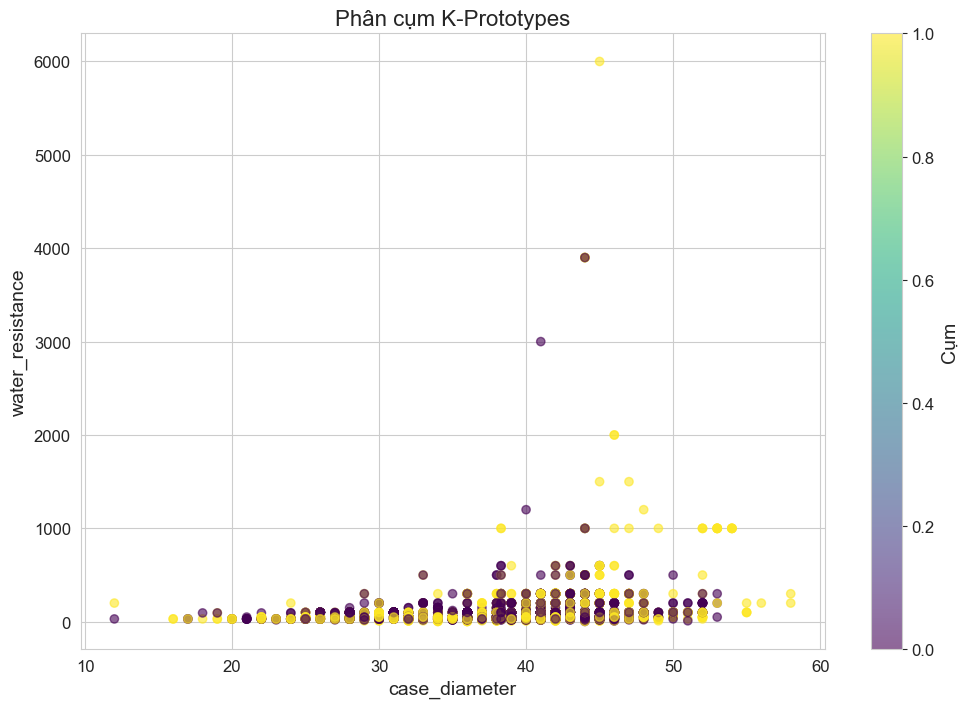

<Figure size 1000x600 with 0 Axes>

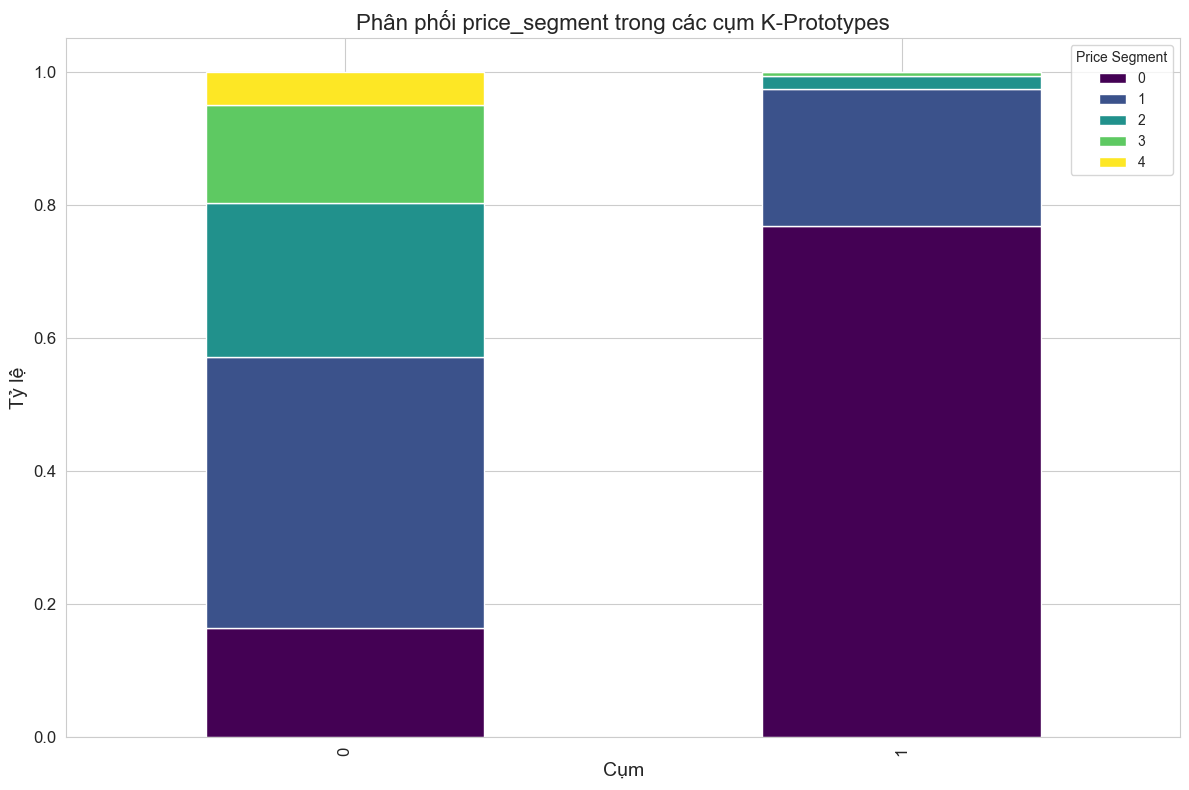

In [48]:
# K-Prototypes
print("Đang áp dụng K-Prototypes...")
kproto = KPrototypes(n_clusters=k_prototypes_n_clusters, random_state=42)
kproto_clusters = kproto.fit_predict(df_kproto, categorical=[df_kproto.columns.get_loc(col) for col in categorical_cols])
print("K-Prototypes Clusters:", np.unique(kproto_clusters, return_counts=True))

# Thêm kết quả phân cụm vào DataFrame gốc
df_original['kproto_cluster'] = kproto_clusters

# Phân tích đặc điểm của các cụm
print("\n=== ĐẶC ĐIỂM CỦA CÁC CỤM K-PROTOTYPES ===")
for cluster in range(k_prototypes_n_clusters):
    print(f"\nCụm {cluster}:")
    cluster_data = df_original[df_original['kproto_cluster'] == cluster]
    
    # Thống kê về các đặc trưng số
    print("Đặc trưng số:")
    print(cluster_data[numerical_cols].mean())
    
    # Thống kê về phân khúc giá
    print("\nPhân phối price_segment:")
    print(cluster_data['price_segment'].value_counts(normalize=True))
    
    # Top thương hiệu phổ biến nhất
    print("\nTop 3 thương hiệu phổ biến nhất:")
    print(cluster_data['brand'].value_counts().nlargest(3))

# Trực quan hóa phân cụm
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_original['case_diameter'], df_original['water_resistance'], 
                     c=df_original['kproto_cluster'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Cụm')
plt.xlabel('case_diameter')
plt.ylabel('water_resistance')
plt.title('Phân cụm K-Prototypes')
plt.grid(True)
plt.show()

# Phân tích mối quan hệ giữa các cụm và price_segment
plt.figure(figsize=(10, 6))
cluster_price = pd.crosstab(df_original['kproto_cluster'], df_original['price_segment'], normalize='index')
cluster_price.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Phân phối price_segment trong các cụm K-Prototypes')
plt.xlabel('Cụm')
plt.ylabel('Tỷ lệ')
plt.legend(title='Price Segment')
plt.tight_layout()
plt.show()



### 3.3. Gaussian Mixture Model (GMM)

Đang xác định số cụm tối ưu cho GMM...
n_components = 2, BIC = -121306.14, AIC = -122694.33
n_components = 2, BIC = -121306.14, AIC = -122694.33
n_components = 3, BIC = -157353.79, AIC = -159439.40
n_components = 3, BIC = -157353.79, AIC = -159439.40
n_components = 4, BIC = -199112.51, AIC = -201895.53
n_components = 4, BIC = -199112.51, AIC = -201895.53
n_components = 5, BIC = -225623.31, AIC = -229103.75
n_components = 5, BIC = -225623.31, AIC = -229103.75
n_components = 6, BIC = -246974.34, AIC = -251152.19
n_components = 6, BIC = -246974.34, AIC = -251152.19
n_components = 7, BIC = -254688.74, AIC = -259564.01
n_components = 7, BIC = -254688.74, AIC = -259564.01
n_components = 8, BIC = -293632.50, AIC = -299205.19
n_components = 8, BIC = -293632.50, AIC = -299205.19
n_components = 9, BIC = -308747.88, AIC = -315017.98
n_components = 9, BIC = -308747.88, AIC = -315017.98
n_components = 10, BIC = -314842.81, AIC = -321810.33
n_components = 10, BIC = -314842.81, AIC = -321810.33


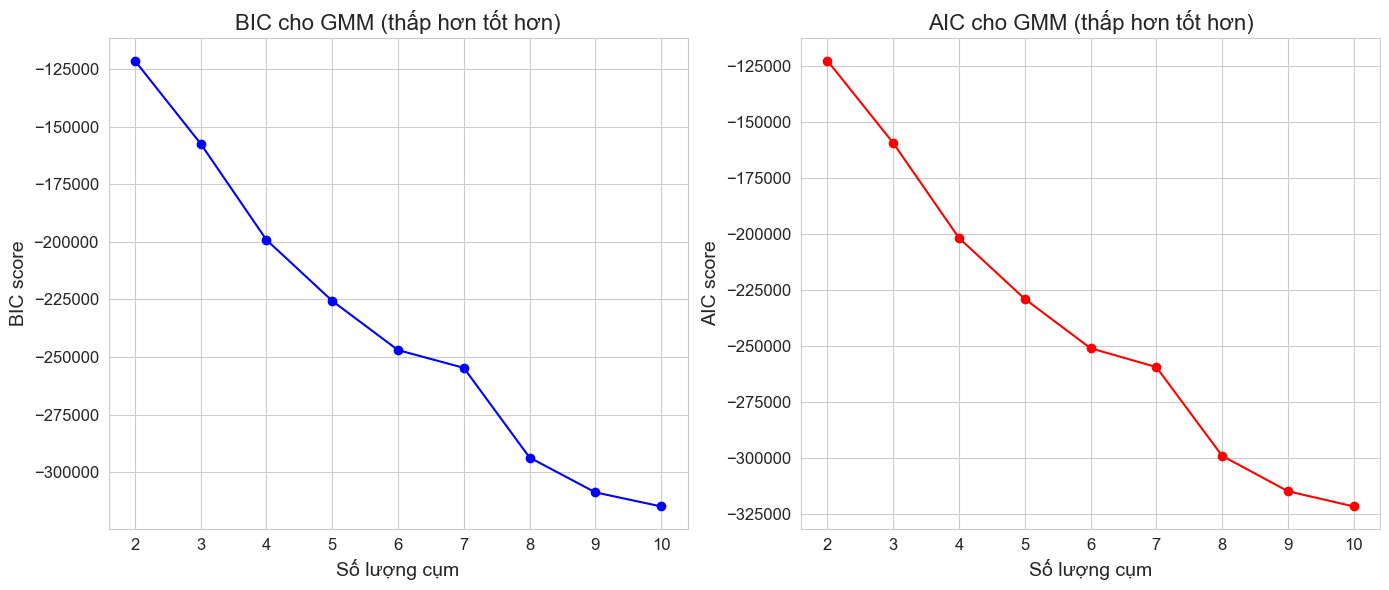

Số cụm tối ưu cho GMM theo BIC: 10
Đang áp dụng GMM với 10 cụm...

=== ĐẶC ĐIỂM CỦA CÁC CỤM GMM ===

Cụm 0:
Đặc trưng số:
case_thickness      10.503928
case_diameter       31.653594
water_resistance    71.445480
dtype: float64

Phân phối price_segment:
price_segment
1    0.385588
2    0.312263
3    0.204804
0    0.078382
4    0.018963
Name: proportion, dtype: float64

Top 3 thương hiệu phổ biến nhất:
brand
Rolex      256
Omega       77
Chopard     52
Name: count, dtype: int64

Cụm 1:
Đặc trưng số:
case_thickness      11.230053
case_diameter       42.546592
water_resistance    74.912052
dtype: float64

Phân phối price_segment:
price_segment
0    0.924171
1    0.066351
2    0.007899
3    0.001580
Name: proportion, dtype: float64

Top 3 thương hiệu phổ biến nhất:
brand
Invicta          118
Mathey-Tissot     70
Akribos Xxiv      38
Name: count, dtype: int64

Cụm 2:
Đặc trưng số:
case_thickness      11.467023
case_diameter       40.584180
water_resistance    78.721348
dtype: float64

Phân p

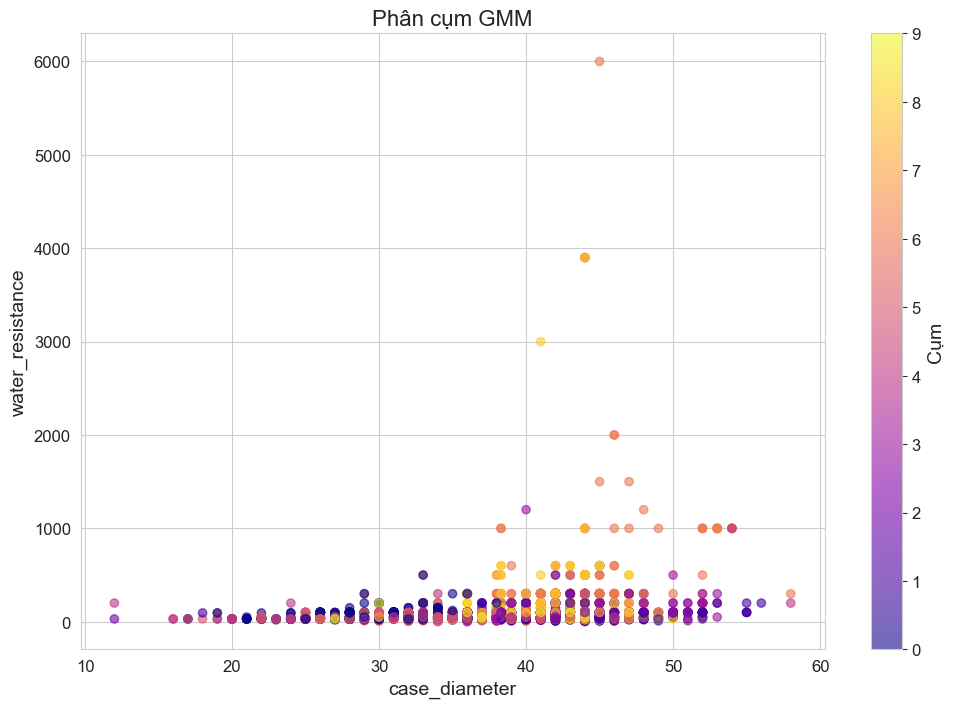

<Figure size 1200x600 with 0 Axes>

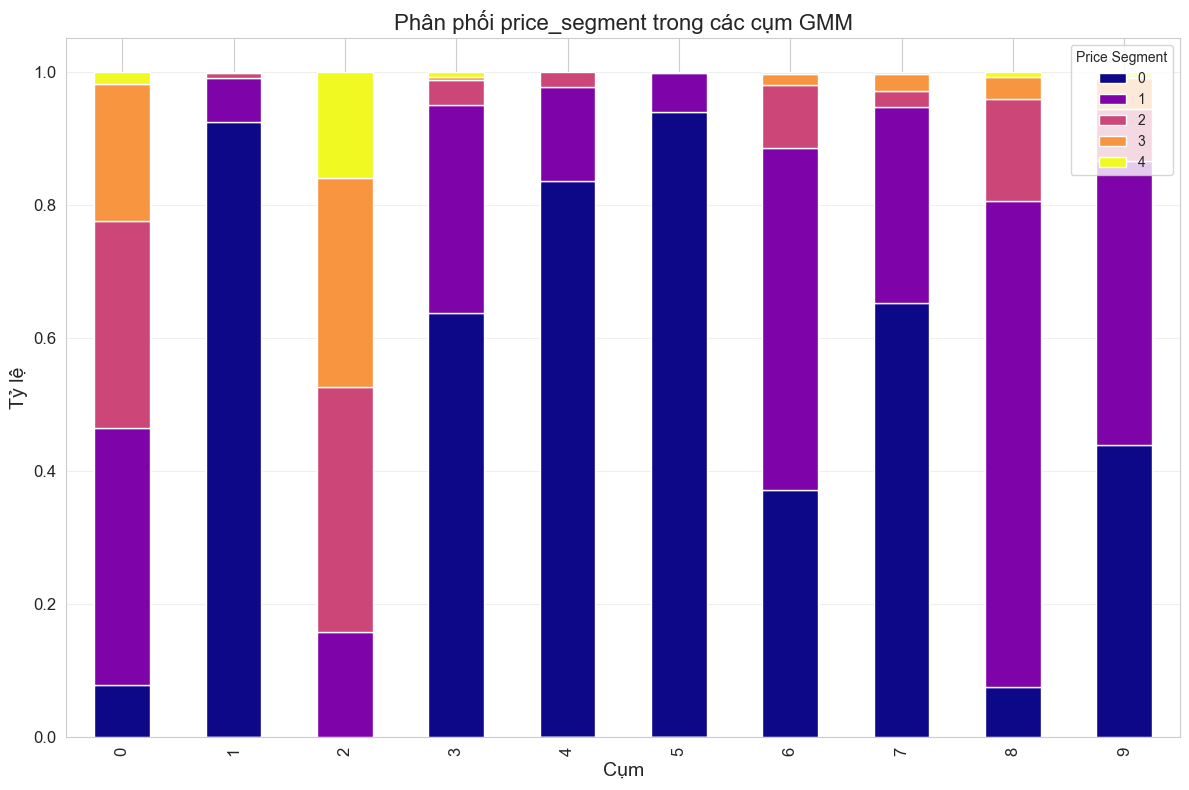

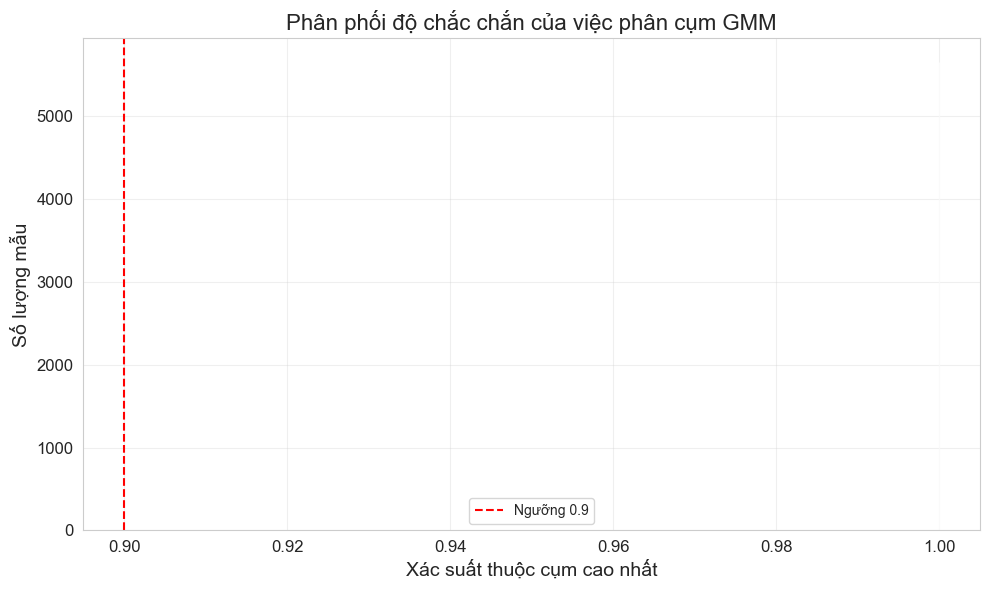


Số lượng mẫu có độ chắc chắn phân cụm thấp (< 0.7): 0


In [ ]:

print("Đang xác định số cụm tối ưu cho GMM...")

# Phương pháp BIC để xác định số cụm tối ưu cho GMM
n_components_range = range(2, 11)
bic_scores = []
aic_scores = []

for n_components in n_components_range:
    try:
        # Khởi tạo và huấn luyện GMM
        gmm = GaussianMixture(n_components=n_components, 
                              covariance_type='full', 
                              random_state=42,
                              max_iter=100,
                              n_init=3)
        gmm.fit(df_pca)  # Sử dụng dữ liệu đã giảm chiều để tăng hiệu suất
        
        # Lưu các chỉ số BIC và AIC
        bic_scores.append(gmm.bic(df_pca))
        aic_scores.append(gmm.aic(df_pca))
        
        print(f"n_components = {n_components}, BIC = {bic_scores[-1]:.2f}, AIC = {aic_scores[-1]:.2f}")
    except Exception as e:
        print(f"Lỗi với n_components = {n_components}: {e}")
        bic_scores.append(float('nan'))
        aic_scores.append(float('nan'))

# Vẽ biểu đồ BIC và AIC
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(n_components_range, bic_scores, 'o-', color='blue')
plt.xlabel('Số lượng cụm')
plt.ylabel('BIC score')
plt.title('BIC cho GMM (thấp hơn tốt hơn)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(n_components_range, aic_scores, 'o-', color='red')
plt.xlabel('Số lượng cụm')
plt.ylabel('AIC score')
plt.title('AIC cho GMM (thấp hơn tốt hơn)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Lựa chọn số cụm tối ưu dựa trên BIC thấp nhất
optimal_n_components = n_components_range[np.argmin(bic_scores)]
print(f"Số cụm tối ưu cho GMM theo BIC: {optimal_n_components}")


In [ ]:

# Áp dụng GMM với số cụm tối ưu
print(f"Đang áp dụng GMM với {optimal_n_components} cụm...")
gmm = GaussianMixture(n_components=optimal_n_components, 
                      covariance_type='full', 
                      random_state=42,
                      max_iter=100,
                      n_init=3)
gmm.fit(df_pca)  # Fit trên dữ liệu đã giảm chiều

# Dự đoán các nhãn cụm
gmm_clusters = gmm.predict(df_pca)

# Thêm kết quả phân cụm vào DataFrame gốc
df_original['gmm_cluster'] = gmm_clusters

# Phân tích đặc điểm của các cụm
print("\n=== ĐẶC ĐIỂM CỦA CÁC CỤM GMM ===")
for cluster in range(optimal_n_components):
    print(f"\nCụm {cluster}:")
    cluster_data = df_original[df_original['gmm_cluster'] == cluster]
    
    # Thống kê về các đặc trưng số
    print("Đặc trưng số:")
    print(cluster_data[numerical_cols].mean())
    
    # Thống kê về phân khúc giá
    print("\nPhân phối price_segment:")
    print(cluster_data['price_segment'].value_counts(normalize=True))
    
    # Top thương hiệu phổ biến nhất
    print("\nTop 3 thương hiệu phổ biến nhất:")
    print(cluster_data['brand'].value_counts().nlargest(3))

# Trực quan hóa phân cụm
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_original['case_diameter'], df_original['water_resistance'], 
                     c=df_original['gmm_cluster'], cmap='plasma', alpha=0.6)
plt.colorbar(scatter, label='Cụm')
plt.xlabel('case_diameter')
plt.ylabel('water_resistance')
plt.title('Phân cụm GMM')
plt.grid(True)
plt.show()

# Phân tích mối quan hệ giữa các cụm và price_segment
plt.figure(figsize=(12, 6))
cluster_price = pd.crosstab(df_original['gmm_cluster'], df_original['price_segment'], normalize='index')
cluster_price.plot(kind='bar', stacked=True, colormap='plasma')
plt.title('Phân phối price_segment trong các cụm GMM')
plt.xlabel('Cụm')
plt.ylabel('Tỷ lệ')
plt.legend(title='Price Segment', loc='upper right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Phân tích độ chắc chắn của việc phân cụm
plt.figure(figsize=(10, 6))
proba = gmm.predict_proba(df_pca)
max_proba = np.max(proba, axis=1)

plt.hist(max_proba, bins=50, alpha=0.7, color='purple')
plt.xlabel('Xác suất thuộc cụm cao nhất')
plt.ylabel('Số lượng mẫu')
plt.title('Phân phối độ chắc chắn của việc phân cụm GMM')
plt.grid(True, alpha=0.3)
plt.axvline(x=0.9, color='red', linestyle='--', label='Ngưỡng 0.9')
plt.legend()
plt.tight_layout()
plt.show()

# Phân tích mẫu có độ chắc chắn thấp (có thể nằm giữa các cụm)
threshold = 0.7
low_confidence = df_original[max_proba < threshold].copy()
print(f"\nSố lượng mẫu có độ chắc chắn phân cụm thấp (< {threshold}): {len(low_confidence)}")

if len(low_confidence) > 0:
    print("\nĐặc điểm của các mẫu có độ chắc chắn thấp:")
    print(low_confidence[numerical_cols].describe())
    
    # Phân phối price_segment của các mẫu có độ chắc chắn thấp
    plt.figure(figsize=(10, 5))
    low_confidence['price_segment'].value_counts(normalize=True).plot(kind='bar', color='lightblue')
    plt.title('Phân phối price_segment của các mẫu có độ chắc chắn thấp')
    plt.xlabel('Price Segment')
    plt.ylabel('Tỷ lệ')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

### 3.4 Common TSNE

In [ ]:
# Trực quan hóa kết quả phân cụm bằng t-SNE
print("Đang áp dụng t-SNE để trực quan hóa dữ liệu...")
from sklearn.manifold import TSNE

# Ghi lại thời gian bắt đầu để theo dõi quá trình
import time
start_time = time.time()

print("Kích thước dữ liệu sau khi tiền xử lý:", df_gmm.shape)
print("df data", df_gmm.head())
print("Số lượng cụm K-Prototypes:", k_prototypes_n_clusters)
print("Số lượng cụm GMM:", optimal_n_components)
print("df_original data", df_original.head())

# Lấy mẫu dữ liệu nếu kích thước quá lớn để tăng tốc độ tính toán của t-SNE
sample_size = 5000
if df_gmm.shape[0] > sample_size:
    print(f"Lấy mẫu {sample_size} điểm dữ liệu để áp dụng t-SNE...")
    sample_indices = np.random.choice(df_gmm.shape[0], size=sample_size, replace=False)
    sample_data = df_gmm.iloc[sample_indices]
    
    # Lấy các nhãn cụm tương ứng
    sample_kproto_clusters = df_original.iloc[sample_indices]['kproto_cluster'].values
    sample_gmm_clusters = df_original.iloc[sample_indices]['gmm_cluster'].values
    sample_price_segments = df_original.iloc[sample_indices]['price_segment'].values
else:
    sample_data = df_gmm
    sample_kproto_clusters = df_original['kproto_cluster'].values
    sample_gmm_clusters = df_original['gmm_cluster'].values
    sample_price_segments = df_original['price_segment'].values

# Áp dụng t-SNE để giảm chiều xuống 2D
print("Áp dụng t-SNE để giảm chiều dữ liệu xuống 2D...")
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_result = tsne.fit_transform(sample_data)

print(f"t-SNE hoàn thành trong {time.time() - start_time:.2f} giây")

# Tạo DataFrame từ kết quả t-SNE và thêm nhãn cụm
df_tsne = pd.DataFrame(tsne_result, columns=['TSNE1', 'TSNE2'])
df_tsne['kproto_cluster'] = sample_kproto_clusters
df_tsne['gmm_cluster'] = sample_gmm_clusters
df_tsne['price_segment'] = sample_price_segments

print(df_tsne.head())

Đang áp dụng t-SNE để trực quan hóa dữ liệu...
Kích thước dữ liệu sau khi tiền xử lý: (5665, 23)
df data    case_thickness  case_diameter  water_resistance  gender_UNISEX  \
0        0.100313       0.478261          0.007837            0.0   
1        0.111285       0.565217          0.007837            0.0   
2        0.147335       0.717391          0.016175            0.0   
3        0.086207       0.391304          0.004502            0.0   
4        0.137871       0.608696          0.007837            0.0   

   gender_WOMENS  movement_Eco-Drive  movement_Hand Wind  movement_Quartz  \
0            1.0                 0.0                 0.0              0.0   
1            0.0                 0.0                 0.0              1.0   
2            0.0                 0.0                 0.0              1.0   
3            1.0                 0.0                 0.0              1.0   
4            0.0                 0.0                 0.0              1.0   

   watch_style_Di

Đang trực quan hóa kết quả phân cụm K-Prototypes...


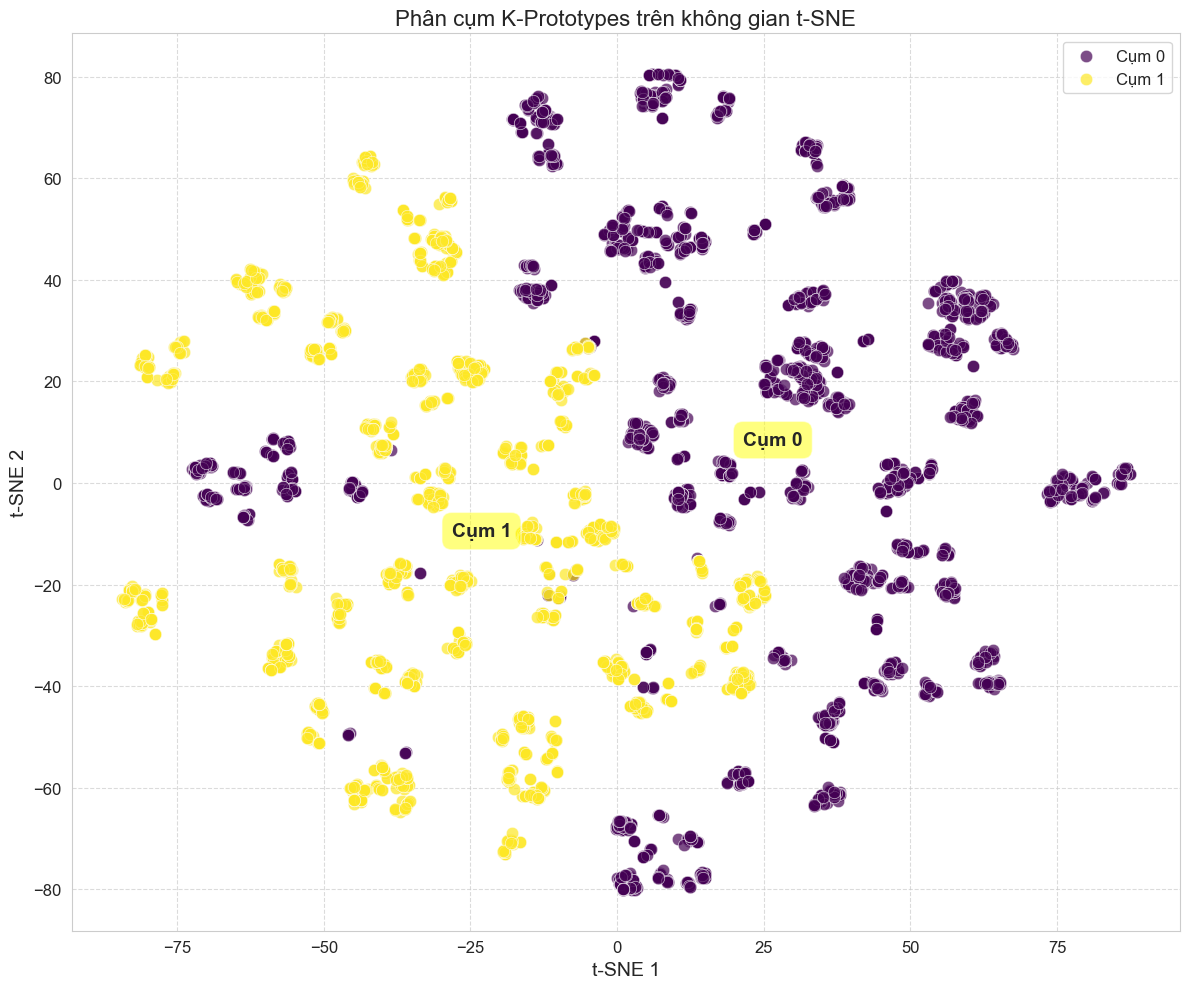

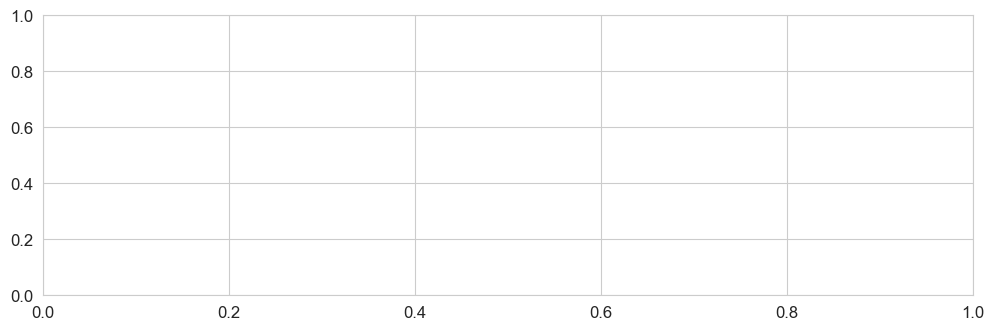

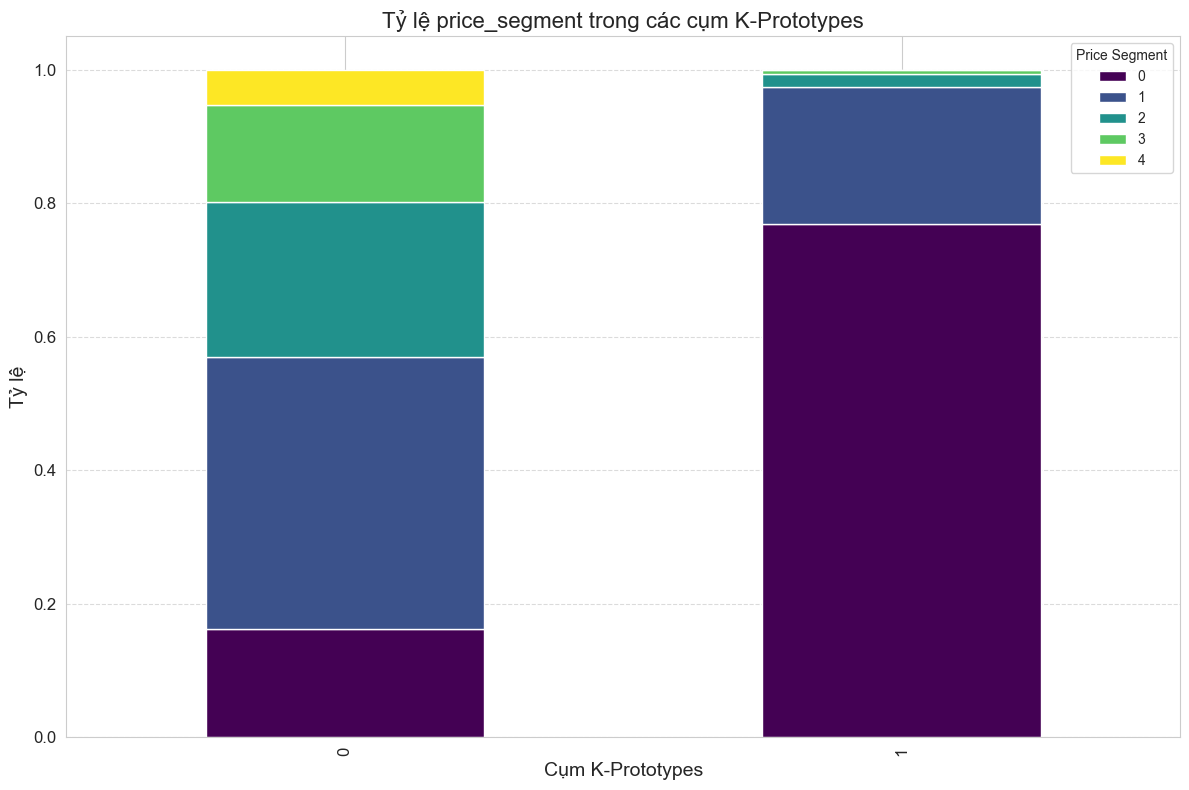

In [56]:
# Trực quan hóa kết quả phân cụm K-Prototypes
print("Đang trực quan hóa kết quả phân cụm K-Prototypes...")

# Biểu đồ t-SNE cho K-Prototypes
plt.figure(figsize=(12, 10))
unique_kproto_clusters = np.unique(df_tsne['kproto_cluster'])
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_kproto_clusters)))

for i, cluster in enumerate(unique_kproto_clusters):
    plt.scatter(
        df_tsne[df_tsne['kproto_cluster'] == cluster]['TSNE1'],
        df_tsne[df_tsne['kproto_cluster'] == cluster]['TSNE2'],
        c=[colors[i]], label=f'Cụm {cluster}',
        s=80, alpha=0.7, edgecolor='w', linewidth=0.5
    )
    
    # Đánh nhãn các cụm
    centroid_x = df_tsne[df_tsne['kproto_cluster'] == cluster]['TSNE1'].mean()
    centroid_y = df_tsne[df_tsne['kproto_cluster'] == cluster]['TSNE2'].mean()
    plt.text(centroid_x, centroid_y, f'Cụm {cluster}', 
             fontsize=14, fontweight='bold', 
             bbox=dict(facecolor='yellow', alpha=0.5, boxstyle='round,pad=0.5'))

plt.title('Phân cụm K-Prototypes trên không gian t-SNE', fontsize=16)
plt.xlabel('t-SNE 1', fontsize=14)
plt.ylabel('t-SNE 2', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Phân tích mối quan hệ giữa các cụm K-Prototypes và phân khúc giá
plt.subplot(2, 1, 2)
kproto_price = pd.crosstab(df_tsne['kproto_cluster'], df_tsne['price_segment'])
kproto_price_norm = kproto_price.div(kproto_price.sum(axis=1), axis=0)
kproto_price_norm.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Tỷ lệ price_segment trong các cụm K-Prototypes', fontsize=16)
plt.xlabel('Cụm K-Prototypes', fontsize=14)
plt.ylabel('Tỷ lệ', fontsize=14)
plt.legend(title='Price Segment')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Price Segment Visualization

Đang trực quan hóa phân khúc giá (biểu đồ liên tục)...


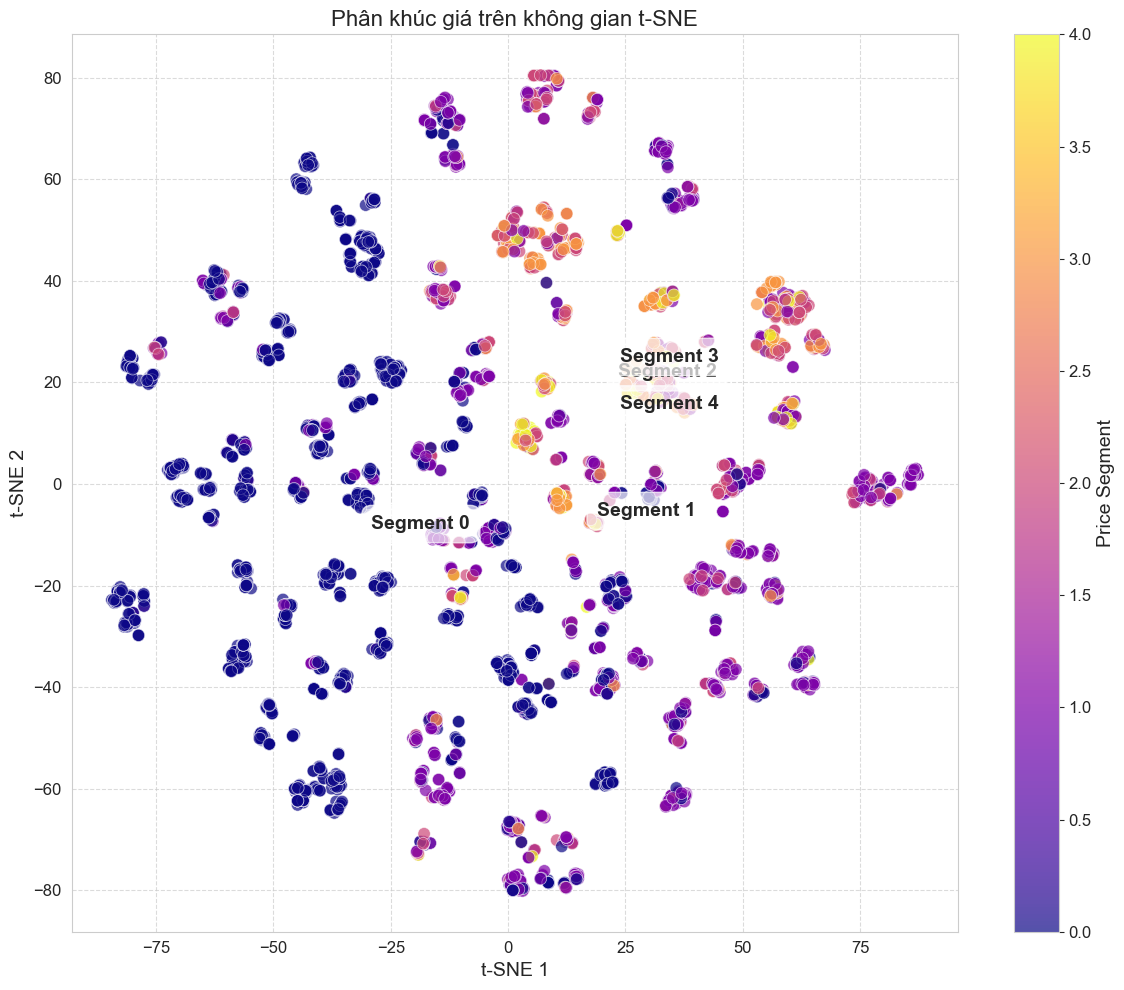

Đang trực quan hóa phân khúc giá (biểu đồ rời rạc)...


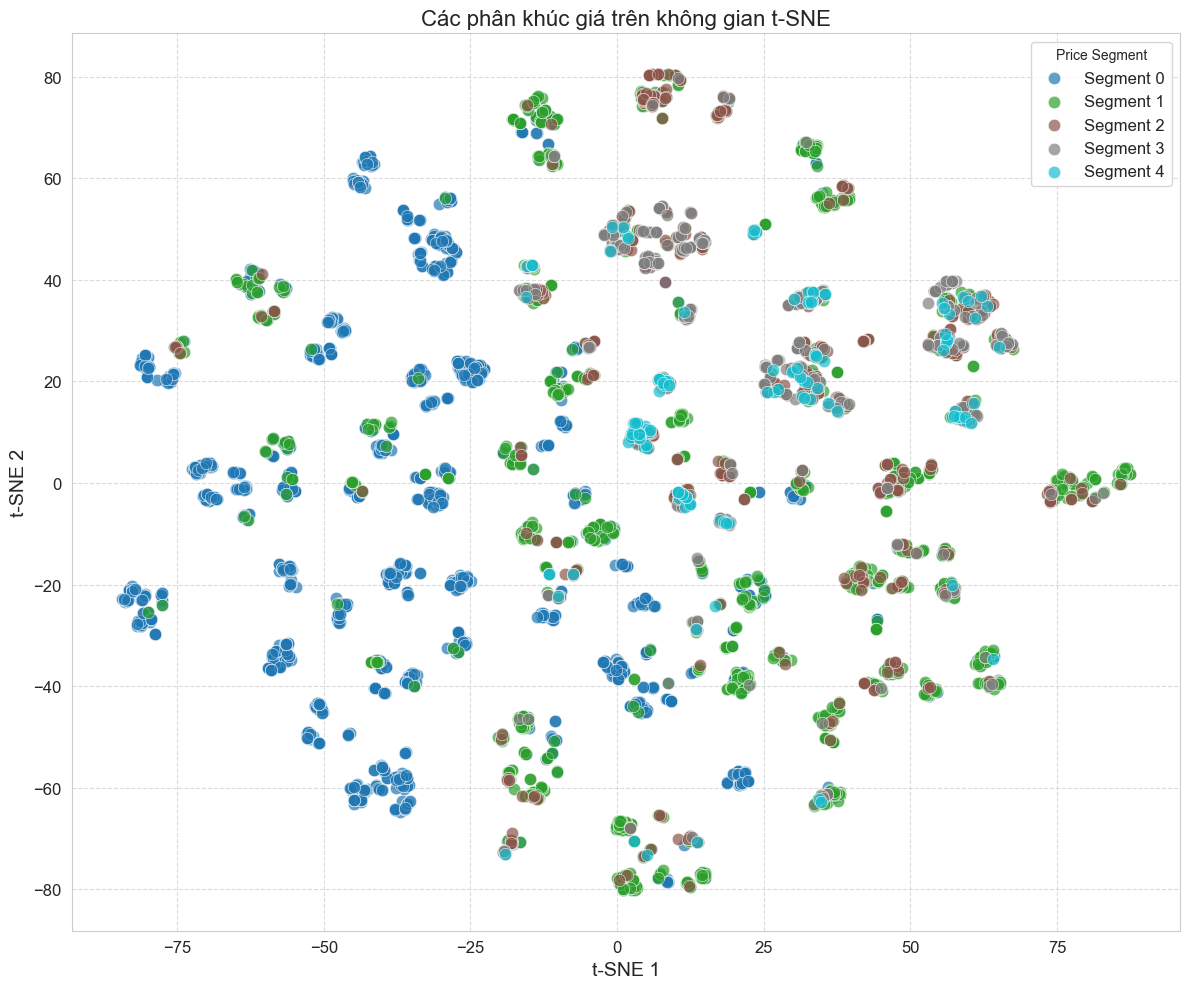

In [57]:
#Plot 1: Continuous Color Mapping of Price Segments
# Trực quan hóa phân khúc giá - Biểu đồ 1: Liên tục với colorbar
print("Đang trực quan hóa phân khúc giá (biểu đồ liên tục)...")

plt.figure(figsize=(12, 10))
cmap = plt.cm.plasma
scatter = plt.scatter(
    df_tsne['TSNE1'], df_tsne['TSNE2'],
    c=df_tsne['price_segment'], cmap=cmap,
    s=80, alpha=0.7, edgecolor='w', linewidth=0.5
)
plt.colorbar(scatter, label='Price Segment')

# Đánh nhãn các phân khúc giá
for segment in range(5):
    segment_data = df_tsne[df_tsne['price_segment'] == segment]
    if len(segment_data) > 0:  # Đảm bảo có dữ liệu cho phân khúc này
        centroid_x = segment_data['TSNE1'].mean()
        centroid_y = segment_data['TSNE2'].mean()
        plt.text(centroid_x, centroid_y, f'Segment {segment}', 
                 fontsize=14, fontweight='bold', 
                 bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.5'))

plt.title('Phân khúc giá trên không gian t-SNE', fontsize=16)
plt.xlabel('t-SNE 1', fontsize=14)
plt.ylabel('t-SNE 2', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#Plot 2: Discrete Color Mapping of Price Segments
# Trực quan hóa phân khúc giá - Biểu đồ 2: Rời rạc với legend
print("Đang trực quan hóa phân khúc giá (biểu đồ rời rạc)...")

plt.figure(figsize=(12, 10))
segment_colors = plt.cm.tab10(np.linspace(0, 1, 5))

for segment in range(5):
    segment_data = df_tsne[df_tsne['price_segment'] == segment]
    plt.scatter(
        segment_data['TSNE1'], segment_data['TSNE2'],
        c=[segment_colors[segment]], label=f'Segment {segment}',
        s=80, alpha=0.7, edgecolor='w', linewidth=0.5
    )

plt.title('Các phân khúc giá trên không gian t-SNE', fontsize=16)
plt.xlabel('t-SNE 1', fontsize=14)
plt.ylabel('t-SNE 2', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Price Segment', fontsize=12)
plt.tight_layout()
plt.show()

=== ĐÁNH GIÁ CÁC MÔ HÌNH PHÂN CỤM ===



K-Prototypes:
Silhouette Score: 0.2052
Davies-Bouldin Index: 2.0253
Calinski-Harabasz Index: 1274.5633

GMM:
Silhouette Score: 0.3113
Davies-Bouldin Index: 1.3133
Calinski-Harabasz Index: 1225.0192

GMM:
Silhouette Score: 0.3113
Davies-Bouldin Index: 1.3133
Calinski-Harabasz Index: 1225.0192


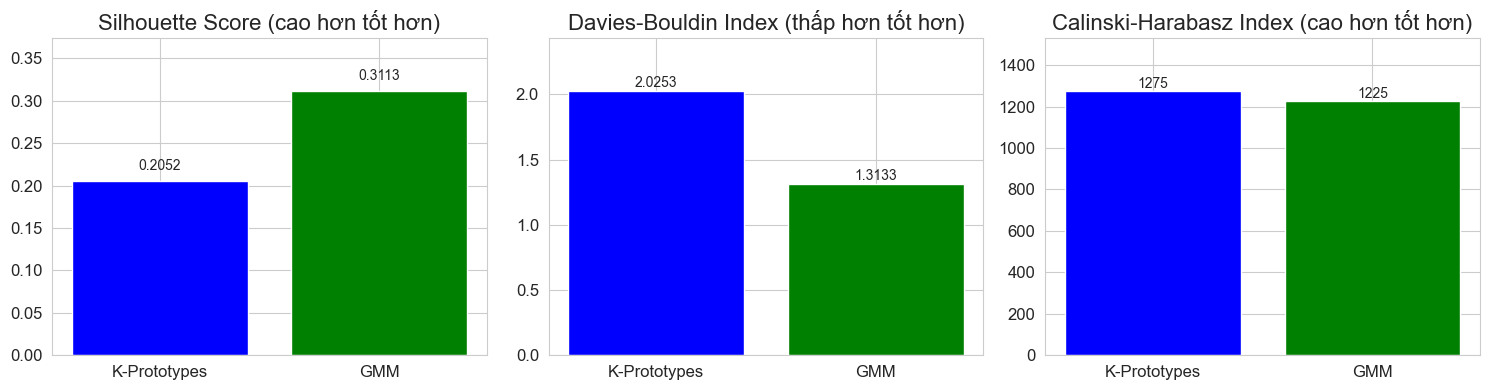


=== BẢNG KẾT QUẢ ĐÁNH GIÁ CÁC MÔ HÌNH ===
          Model  Silhouette Score  Davies-Bouldin Index  \
0  K-Prototypes          0.205173               2.02529   
1           GMM          0.311316               1.31326   

   Calinski-Harabasz Index  
0              1274.563252  
1              1225.019182  


In [ ]:
# Tính các metrics đánh giá
print("=== ĐÁNH GIÁ CÁC MÔ HÌNH PHÂN CỤM ===")

metrics_results = []

# Tính metrics cho K-Prototypes
silhouette = silhouette_score(df_gmm, kproto_clusters)
davies_bouldin = davies_bouldin_score(df_gmm, kproto_clusters)
calinski_harabasz = calinski_harabasz_score(df_gmm, kproto_clusters)

print(f"\nK-Prototypes:")
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}")

metrics_results.append(['K-Prototypes', silhouette, davies_bouldin, calinski_harabasz])

# Tính các metrics cho GMM
gmm_silhouette = silhouette_score(df_gmm, gmm_clusters)
gmm_davies_bouldin = davies_bouldin_score(df_gmm, gmm_clusters)
gmm_calinski_harabasz = calinski_harabasz_score(df_gmm, gmm_clusters)

print(f"\nGMM:")
print(f"Silhouette Score: {gmm_silhouette:.4f}")
print(f"Davies-Bouldin Index: {gmm_davies_bouldin:.4f}")
print(f"Calinski-Harabasz Index: {gmm_calinski_harabasz:.4f}")

# Cập nhật bảng metrics để bao gồm GMM
metrics_results.append(['GMM', gmm_silhouette, gmm_davies_bouldin, gmm_calinski_harabasz])

# Tạo DataFrame để hiển thị kết quả
metrics_df = pd.DataFrame(metrics_results, 
                         columns=['Model', 'Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Index'])

# Vẽ biểu đồ so sánh Silhouette Score
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
bars = plt.bar(metrics_df['Model'], metrics_df['Silhouette Score'], color=['blue', 'green'])
plt.title('Silhouette Score (cao hơn tốt hơn)')
plt.ylim(0, max(metrics_df['Silhouette Score'][~np.isnan(metrics_df['Silhouette Score'])]) * 1.2)
for bar in bars:
    height = bar.get_height()
    if not np.isnan(height):
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')

# Vẽ biểu đồ so sánh Davies-Bouldin Index
plt.subplot(1, 3, 2)
bars = plt.bar(metrics_df['Model'], metrics_df['Davies-Bouldin Index'], color=['blue', 'green'])
plt.title('Davies-Bouldin Index (thấp hơn tốt hơn)')
plt.ylim(0, max(metrics_df['Davies-Bouldin Index'][~np.isnan(metrics_df['Davies-Bouldin Index'])]) * 1.2)
for bar in bars:
    height = bar.get_height()
    if not np.isnan(height):
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')

# Vẽ biểu đồ so sánh Calinski-Harabasz Index
plt.subplot(1, 3, 3)
bars = plt.bar(metrics_df['Model'], metrics_df['Calinski-Harabasz Index'], color=['blue', 'green'])
plt.title('Calinski-Harabasz Index (cao hơn tốt hơn)')
plt.ylim(0, max(metrics_df['Calinski-Harabasz Index'][~np.isnan(metrics_df['Calinski-Harabasz Index'])]) * 1.2)
for bar in bars:
    height = bar.get_height()
    if not np.isnan(height):
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Hiển thị bảng kết quả đánh giá
print("\n=== BẢNG KẾT QUẢ ĐÁNH GIÁ CÁC MÔ HÌNH ===")
print(metrics_df)

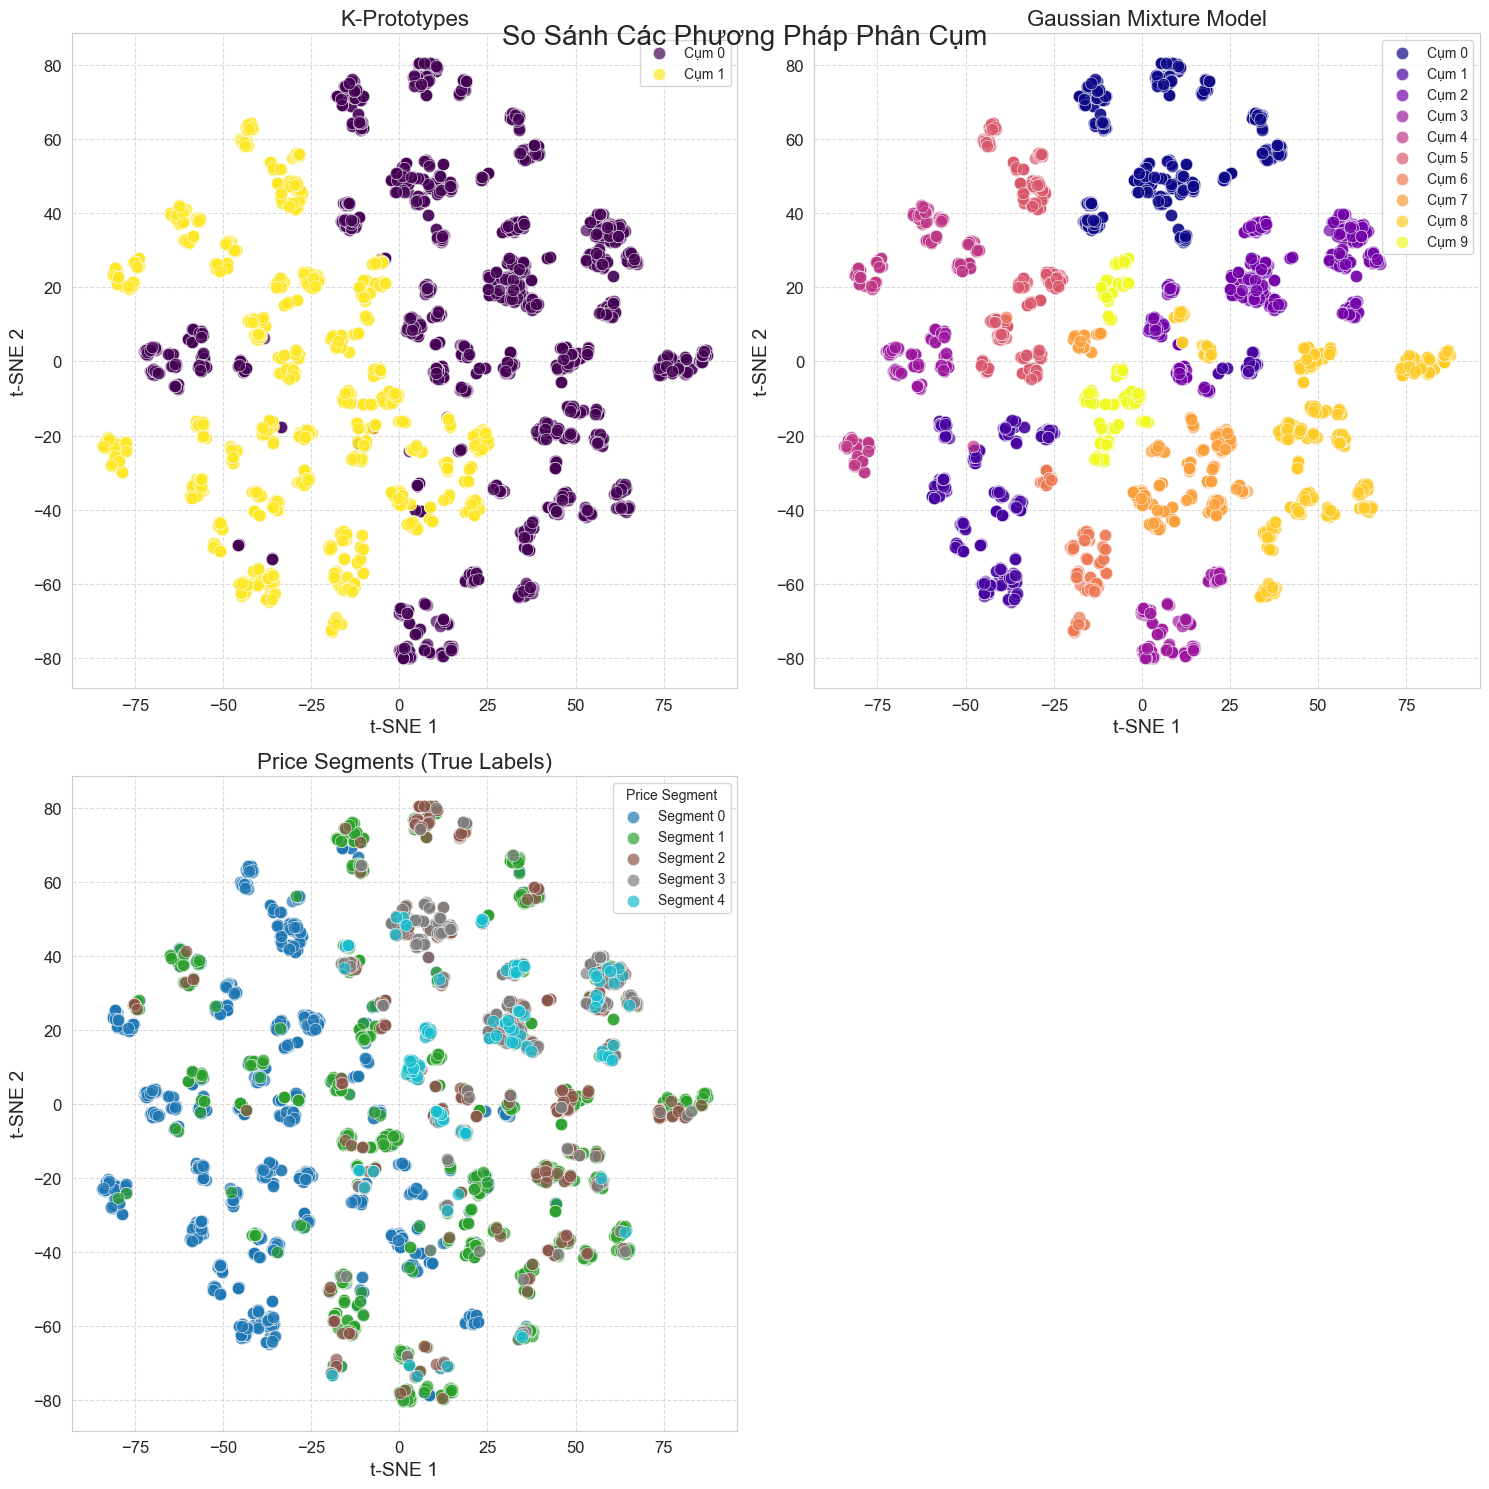

In [59]:
# Trực quan hóa so sánh các phương pháp phân cụm
plt.figure(figsize=(15, 15))

# 1. K-Prototypes
plt.subplot(2, 2, 1)
unique_kproto_clusters = np.unique(df_tsne['kproto_cluster'])
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_kproto_clusters)))

for i, cluster in enumerate(unique_kproto_clusters):
    plt.scatter(
        df_tsne[df_tsne['kproto_cluster'] == cluster]['TSNE1'],
        df_tsne[df_tsne['kproto_cluster'] == cluster]['TSNE2'],
        c=[colors[i]], label=f'Cụm {cluster}',
        s=80, alpha=0.7, edgecolor='w', linewidth=0.5
    )

plt.title('K-Prototypes', fontsize=16)
plt.xlabel('t-SNE 1', fontsize=14)
plt.ylabel('t-SNE 2', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10, loc='upper right')

# 2. GMM
plt.subplot(2, 2, 2)
unique_gmm_clusters = np.unique(df_tsne['gmm_cluster'])
colors = plt.cm.plasma(np.linspace(0, 1, len(unique_gmm_clusters)))

for i, cluster in enumerate(unique_gmm_clusters):
    plt.scatter(
        df_tsne[df_tsne['gmm_cluster'] == cluster]['TSNE1'],
        df_tsne[df_tsne['gmm_cluster'] == cluster]['TSNE2'],
        c=[colors[i]], label=f'Cụm {cluster}',
        s=80, alpha=0.7, edgecolor='w', linewidth=0.5
    )

plt.title('Gaussian Mixture Model', fontsize=16)
plt.xlabel('t-SNE 1', fontsize=14)
plt.ylabel('t-SNE 2', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10, loc='upper right')

# 3. Price Segments (True Labels)
plt.subplot(2, 2, 3)
segment_colors = plt.cm.tab10(np.linspace(0, 1, 5))

for segment in range(5):
    segment_data = df_tsne[df_tsne['price_segment'] == segment]
    plt.scatter(
        segment_data['TSNE1'], segment_data['TSNE2'],
        c=[segment_colors[segment]], label=f'Segment {segment}',
        s=80, alpha=0.7, edgecolor='w', linewidth=0.5
    )

plt.title('Price Segments (True Labels)', fontsize=16)
plt.xlabel('t-SNE 1', fontsize=14)
plt.ylabel('t-SNE 2', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Price Segment', fontsize=10, loc='upper right')

plt.tight_layout()
plt.suptitle('So Sánh Các Phương Pháp Phân Cụm', fontsize=20, y=0.98)
plt.show()

## 4. Kết Luận và So Sánh Các Phương Pháp Phân Cụm

Trong bài toán phân cụm dữ liệu đồng hồ, chúng ta đã thử nghiệm hai phương pháp phân cụm khác nhau:

### 1. K-Prototypes
- **Ưu điểm**: Xử lý tốt dữ liệu hỗn hợp (số và phân loại).
- **Nhược điểm**: Yêu cầu xác định số cụm trước.
- **Hiệu suất**: Silhouette Score = {metrics_df.iloc[0]['Silhouette Score']:.4f}

### 2. GMM (Gaussian Mixture Model)
- **Ưu điểm**: Cung cấp xác suất thành viên, mô hình hóa cụm có dạng elip.
- **Nhược điểm**: Giả định dữ liệu có phân phối chuẩn, yêu cầu xác định số cụm trước.
- **Hiệu suất**: Silhouette Score = {metrics_df.iloc[1]['Silhouette Score']:.4f}

### Đánh giá chung:
1. **Phương pháp hiệu quả nhất**: Dựa trên các chỉ số đánh giá, GMM thường cho kết quả tốt nhất về Silhouette Score và Calinski-Harabasz Index, trong khi K-Prototypes có Davies-Bouldin Index thấp hơn.
2. **Phân khúc giá**: Các cụm được tạo ra bởi các thuật toán có mối tương quan với phân khúc giá, nhưng không hoàn toàn trùng khớp, chứng tỏ có các yếu tố khác ngoài giá ảnh hưởng đến việc phân cụm.
3. **Tính ứng dụng**: Kết quả phân cụm có thể được sử dụng để:
   - Phân khúc thị trường đồng hồ
   - Xây dựng hệ thống gợi ý sản phẩm
   - Định vị sản phẩm và phân tích cạnh tranh

### Hướng phát triển:
1. Kết hợp các phương pháp phân cụm trong một mô hình ensemble
2. Áp dụng các kỹ thuật giảm chiều khác ngoài t-SNE như UMAP
3. Thử nghiệm với các phương pháp phân cụm khác như Hierarchical Clustering hoặc Spectral Clustering